In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import datetime
import tensorflow as tf
import os
import warnings
import adaptfilt
import sys

import time as t

from keras import backend as K

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D, Conv2D, AveragePooling1D, AveragePooling2D,\
LocallyConnected1D, MaxPooling1D, Reshape, UpSampling1D, UpSampling2D, Conv2DTranspose

from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

from sys import platform

from copy import deepcopy

#all the functions are in this module
from EEGAnalysis import *

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
global run
run = 4000

In [3]:
def newSession(GPU=0, CPU=8, randomSeed = 8):
    #delete previous model and set up session. Also resets the random seed.
    np.random.seed(randomSeed)
    tf.keras.backend.clear_session()
    config = tf.ConfigProto(device_count={'GPU':GPU, 'CPU':CPU})
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    tf.keras.backend.set_session(tf.Session(config=config))
    gc.collect()

In [4]:
def predictClass(xTest, classifier):
    predictions = classifier.predict(xTest)
    return np.array(predictions).flatten()

In [5]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [6]:
filenames = {}
filenames['blinks'] = 'EEGdata/blinks_2019.03.25_14.56.23.edf'
filenames['moveHandsSmall'] = 'EEGdata/move hands_2019.03.25_15.21.13.edf'
filenames['moveHandsBig'] = 'EEGdata/longrecording3srest3sleft3srest3sright_2019.02.18_15.04.30.edf'
filenames['beeps'] = 'EEGdata/beeps_2019.03.25_15.04.47.edf'
filenames['music'] = 'EEGdata/WickedInstrum10sSilence10sMusic_2019.05.13_15.13.18.edf'
filenames['light'] = 'EEGdata/Black-White-Screen10s-StartBlack-adjusting-eyes-open_2019.05.14_14.39.49.edf'

In [7]:
def naiveBayes(experiment, neededForClassifiers, comment = ''):
    #unpack variables
    classes, xTrain, yTrain, xTest, yTest = neededForClassifiers
        
    #import the 'run' variable
    global run, evaluation, fold, classifierID, classifierNames
    
    xTrainFlat = np.reshape(xTrain, (xTrain.shape[0],xTrain.shape[1]*xTrain.shape[2]))
    xTestFlat = np.reshape(xTest, (xTest.shape[0],xTest.shape[1]*xTest.shape[2]))

    #reset classifier:
    classifier = None
    classifier = GaussianNB()
    classifier.fit(xTrainFlat, unpackClasses(yTrain))

    yPred = predictClass(xTestFlat, classifier)
    yTestNumerical = unpackClasses(yTest)
    conf_matrix_test = confusion_matrix(yTestNumerical, yPred)
    score = classifier.score(xTestFlat, unpackClasses(yTest))
    mcc = matthews_corrcoef(yTestNumerical, yPred)
    print('------------------------')
    dispMat(conf_matrix_test, names = classes)
    print('Flattened data yields score:', round(score, 2))
    print('MCC: ', round(mcc, 2))
    #print(f"Classifier: sigma = {classifier.sigma_}, theta = {classifier.theta_}")
    print('------------------------')
    
    #log the results in a .npy file
    logDir = os.getcwd() + '/' + experiment + '/logsNpy'
    results = logDir + '/' + format(run, "04.0f") + '-' + 'NaiveBayes-ConfusionMatrix' + '-' + comment

    run += 1
    
    try:
        np.save(results, conf_matrix_test)
        np.save(results + '-sigma', classifier.sigma_)
        np.save(results + '-theta', classifier.theta_)
    except:
        os.makedirs(logDir)
        np.save(results, conf_matrix_test)
        np.save(results + '-sigma', classifier.sigma_)
        np.save(results + '-theta', classifier.theta_)
    
    #for the kFold cross validation
    if fold == 0:
        classifierNames[classifierID] = 'naiveBayes-' + experiment + comment
        evaluation[classifierNames[classifierID]] = []
    classifierID += 1
    return score, mcc

In [8]:
def fullyConnectedNeuralNetwork(experiment, neededForClassifiers, epochs = 150, patience = 100,
                                LR = 1e-3, batch_size = 32, denseLayerSizes = [64, 128], dropouts = [0],
                                comment = ''):
    
    #unpack variables
    classes, xTrain, yTrain, xTest, yTest = neededForClassifiers
        
    #import the 'run' variable
    global run, evaluation, fold, classifierID, classifierNames
    
    #make sure the dropout is read correctly
    if len(dropouts) == 1:
        dropouts = np.full(len(denseLayerSizes), dropouts)
    
    #hyperparameters
    verbose = 0
    loadPreviousModels = False #loads the checkpoints
    loss = 'binary_crossentropy'
    if len(yTest[0]) > 2:
        loss = 'categorical_crossentropy'
    metrics = ['accuracy', mcor]
    min_delta = 1e-5

    #prevent naive model
    classWeight = {}
    for i in range(len(classes)):
        classWeight[i] = unpackClasses(yTrain).tolist().count(i)

    #initiate new tensorflowSession
    newSession(2, 8)

    print(xTrain.shape[0], 'train samples')
    print(xTest.shape[0], 'test samples')

    #build model
    model = Sequential()
    model.add(Flatten(input_shape= (xTrain.shape[1:])))
    for i in range(len(denseLayerSizes)):
        model.add(Dense(denseLayerSizes[i], activation='relu'))
        if len(denseLayerSizes) - i <= len(dropouts): #this makes sure that the dropouts are chosen as last layers,if the arrays are not same size
            model.add(Dropout(rate = dropouts[-len(denseLayerSizes) + i]))
    model.add(Flatten()) #This layer is only there for generalisation of the output
    model.add(Dense(len(yTest[0]), activation='sigmoid'))
    model.summary()

    optimizer = tf.keras.optimizers.Adam(lr=LR)#, decay=1.5)#rho=rho, epsilon=epsilon,
    model.compile(optimizer=optimizer, loss=loss,  metrics=metrics)

    #make filepaths
    networkname = format(run, "04.0f") + '-' + experiment + '-' + comment + '-' + makeNameModel(model)
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    logDir = './' + experiment + '/logs/' + networkname + time
    modelFile = './' + experiment + '/logs/' + networkname + '.hdf5'
    if platform.count('Windows'):
        logDir = os.getcwd() + logDir
        modelFile = os.getcwd() + modelFile
        if not loadPreviousModels:
            os.makedirs(logDir)

    if loadPreviousModels:
        model.load_weights(modelFile)

    # prepare callbacks and checkpoint learning
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=0,
    #                            write_graph=True, write_images=False, write_grads = True)#, update_freq = 'epoch')
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(modelFile, monitor='val_loss', mode = 'min', period=5, save_best_only=False)
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=patience, min_delta = min_delta)
    histories = Histories()

    print(networkname)

    model.fit(xTrain, yTrain, epochs=epochs, batch_size=batch_size, verbose = verbose,
              callbacks = [earlyStopping, histories],
              validation_data=(xTest, yTest), class_weight=classWeight)

    trainResult = np.array([histories.loss, histories.acc, histories.mcor])
    testResult = np.array([histories.val_loss, histories.val_acc, histories.val_mcor])

    score = model.evaluate(xTest, yTest, verbose=1)

    y_pred = model.predict_classes(xTest)
    y_true = unpackClasses(yTest)
    conf_matrix_test = confusion_matrix(y_true, y_pred)
    dispMat(conf_matrix_test, names = classes)

    temp = 0
    for i in model.metrics_names:
        print('Test', str(i), ':', round(score[temp], 2))
        temp += 1
    run += 1
    
    #log the results in a .npy file
    logDir = os.getcwd() + '/' + experiment + '/logsNpy'
    trainFile = logDir + '/' + networkname + '-train'
    testFile = logDir + '/' +  networkname + '-test'

    try:
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
    except:
        os.makedirs(logDir)
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
    
    #for the kFold cross validation
    #for the kFold cross validation
    if fold == 0:
        classifierNames[classifierID] = networkname
        evaluation[classifierNames[classifierID]] = []
    classifierID += 1
    return round(score[1], 4), round(score[2], 4)

In [9]:
def ConvolutionalNeuralNetwork(experiment, neededForClassifiers, epochs = 500, patience = 400,
                               LR = 1e-3, batch_size = 32, denseLayerSizes = [64, 64], dropouts = [0],
                               convolutionalLayerSizes = [32, 32], dimension = '1D', kernelSizes = [40, 40],
                               poolingLayerSizes = None, comment = ''):
    
    #unpack variables
    classes, xTrain, yTrain, xTest, yTest = neededForClassifiers
        
    #import the 'run' variable
    global run, config, evaluation, fold, classifierID, classifierNames
    
    #make sure the dropout is read correctly
    if dropouts and len(dropouts) == 1:
        dropouts = np.full(len(denseLayerSizes), dropouts)
    
    #hyperparameters
    verbose = 0
    loadPreviousModels = False #loads the checkpoints
    loss = 'binary_crossentropy'
    if len(yTest[0]) > 2:
        loss = 'categorical_crossentropy'
    metrics = ['accuracy', mcor]
    min_delta = 1e-5

    #prevent naive model
    classWeight = {}
    for i in range(len(classes)):
        classWeight[i] = unpackClasses(yTrain).tolist().count(i)
    
    #set dimension
    Conv = Conv2D if dimension == '2D' else Conv1D
    AvgPool = AveragePooling2D if dimension == '2D' else AveragePooling1D
    
    if dimension == '2D':
        xTrain = np.expand_dims(xTrain, -1)
        xTest = np.expand_dims(xTest, -1)

    #initiate new tensorflowSession
    newSession(2, 8)

    print(xTrain.shape[0], 'train samples')
    print(xTest.shape[0], 'test samples')

    #build model
    model = Sequential()    
    model.add(Conv(convolutionalLayerSizes[0], kernelSizes[0], input_shape= (xTrain.shape[1:]),
                              activation = 'relu'))
    if poolingLayerSizes:
        model.add(AvgPool(poolingLayerSizes[0]))
    for i in range(len(convolutionalLayerSizes) - 1):
        model.add(Conv(convolutionalLayerSizes[i+1], kernelSizes[i+1], activation = 'relu'))
        try:
            model.add(AvgPool(poolingLayerSizes[i+1]))
        except:
            a = True #do nothing
    model.add(Flatten())
    for i in range(len(denseLayerSizes)):
        model.add(Dense(denseLayerSizes[i], activation='relu'))
        if len(denseLayerSizes) - i <= len(dropouts) and dropouts.any(): #this makes sure that the dropouts are chosen as last layers,if the arrays are not same size
            model.add(Dropout(rate = dropouts[-len(denseLayerSizes) + i]))
    model.add(Flatten()) #This layer is only there for generalisation of the output
    model.add(Dense(len(yTest[0]), activation='sigmoid'))
    model.summary()

    optimizer = tf.keras.optimizers.Adam(lr=LR)#, decay=1.5)#rho=rho, epsilon=epsilon,
    model.compile(optimizer=optimizer, loss=loss,  metrics=metrics)

    #make filepaths
    networkname = format(run, "04.0f") + '-' + experiment + '-' + comment + '-' + makeNameModel(model)
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    logDir = './' + experiment + '/logs/' + networkname + time
    modelFile = './' + experiment + '/logs/' + networkname + '.hdf5'
    if platform.count('Windows'):
        logDir = os.getcwd() + logDir
        modelFile = os.getcwd() + modelFile
        if not loadPreviousModels:
            os.makedirs(logDir)

    if loadPreviousModels:
        model.load_weights(modelFile)

    # prepare callbacks and checkpoint learning
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=0,
    #                            write_graph=True, write_images=False, write_grads = True)#, update_freq = 'epoch')
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(modelFile, monitor='val_loss', mode = 'min', period=5, save_best_only=False)
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=patience, min_delta = min_delta)
    histories = Histories()

    print(networkname)

    model.fit(xTrain, yTrain, epochs=epochs, batch_size=batch_size, verbose = verbose,
              callbacks = [earlyStopping, histories],
              validation_data=(xTest, yTest), class_weight=classWeight)

    trainResult = np.array([histories.loss, histories.acc, histories.mcor])
    testResult = np.array([histories.val_loss, histories.val_acc, histories.val_mcor])

    score = model.evaluate(xTest, yTest, verbose=1)

    y_pred = model.predict_classes(xTest)
    y_true = unpackClasses(yTest)
    conf_matrix_test = confusion_matrix(y_true, y_pred)
    dispMat(conf_matrix_test, names = classes)

    temp = 0
    for i in model.metrics_names:
        print('Test', str(i), ':', round(score[temp], 2))
        temp += 1
    run += 1
    
    #log the results in a .npy file
    logDir = os.getcwd() + '/' + experiment + '/logsNpy'
    trainFile = logDir + '/' + networkname + '-train'
    testFile = logDir + '/' +  networkname + '-test'

    try:
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
    except:
        os.makedirs(logDir)
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
        
    if fold == 0:
        classifierNames[classifierID] = networkname
        evaluation[classifierNames[classifierID]] = []
    classifierID += 1
    return round(score[1], 4), round(score[2], 4)

In [10]:
def smartSpectrum(experiment, neededForClassifiers, epochs = 500, patience = 400, LR = 1e-3, batch_size = 32,
                  denseLayerSizes = [64], dropouts = [0], convolutionalLayerSizes = [1], kernelSizes = [1],
                  poolingLayerSizes = None, comment = ''):
    
    #unpack variables
    classes, xTrain, yTrain, xTest, yTest = neededForClassifiers
    
    #import the 'run' variable
    global run, config, evaluation, fold, classifierID, classifierNames
    
    #make sure the dropout is read correctly
    if dropouts and len(dropouts) == 1:
        dropouts = np.full(len(denseLayerSizes), dropouts)
        
    if len(kernelSizes) == 1:
        kernelSizes = np.expand_dims(np.full(len(convolutionalLayerSizes), kernelSizes), axis = -1)
    
    #hyperparameters
    verbose = 0
    loadPreviousModels = False #loads the checkpoints
    loss = 'binary_crossentropy'
    if len(yTest[0]) > 2:
        loss = 'categorical_crossentropy'
    metrics = ['accuracy', mcor]
    min_delta = 1e-5

    #prevent naive model
    classWeight = {}
    for i in range(len(classes)):
        classWeight[i] = unpackClasses(yTrain).tolist().count(i)

    #initiate new tensorflowSession
    newSession(2, 8)

    print(xTrain.shape[0], 'train samples')
    print(xTest.shape[0], 'test samples')

    #build model
    model = Sequential()    
    model.add(LocallyConnected1D(convolutionalLayerSizes[0], kernelSizes[0], input_shape= (xTrain.shape[1:]),
                              activation = 'relu'))
    if poolingLayerSizes:
        model.add(MaxPooling1D(poolingLayerSizes[0]))
    if len(convolutionalLayerSizes) > 1:
        for i in range(len(convolutionalLayerSizes) - 1):
            model.add(LocallyConnected1D(convolutionalLayerSizes[i+1], kernelSizes[i+1], activation = 'relu'))
            try:
                model.add(AveragePooling1D(poolingLayerSizes[i+1]))
            except:
                a = True #do nothing
    model.add(Flatten())
    for i in range(len(denseLayerSizes)):
        model.add(Dense(denseLayerSizes[i], activation='relu'))
        if len(denseLayerSizes) - i <= len(dropouts) and dropouts.any(): #this makes sure that the dropouts are chosen as last layers,if the arrays are not same size
            model.add(Dropout(rate = dropouts[-len(denseLayerSizes) + i]))
    model.add(Flatten()) #This layer is only there for generalisation of the output
    model.add(Dense(len(yTest[0]), activation='sigmoid'))
    model.summary()

    optimizer = tf.keras.optimizers.Adam(lr=LR)#, decay=1.5)#rho=rho, epsilon=epsilon,
    model.compile(optimizer=optimizer, loss=loss,  metrics=metrics)

    #make filepaths
    networkname = format(run, "04.0f") + '-' + experiment + '-' + comment + '-' + makeNameModel(model)
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    logDir = './' + experiment + '/logs/' + networkname + time
    modelFile = './' + experiment + '/logs/' + networkname + '.hdf5'
    if platform.count('Windows'):
        logDir = os.getcwd() + logDir
        modelFile = os.getcwd() + modelFile
        if not loadPreviousModels:
            os.makedirs(logDir)

    if loadPreviousModels:
        model.load_weights(modelFile)

    # prepare callbacks and checkpoint learning
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=0,
    #                            write_graph=True, write_images=False, write_grads = True)#, update_freq = 'epoch')
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(modelFile, monitor='val_loss', mode = 'min', period=5, save_best_only=False)
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=patience, min_delta = min_delta)
    histories = Histories()

    print(networkname)

    model.fit(xTrain, yTrain, epochs=epochs, batch_size=batch_size, verbose = verbose,
              callbacks = [earlyStopping, histories],
              validation_data=(xTest, yTest), class_weight=classWeight)

    trainResult = np.array([histories.loss, histories.acc, histories.mcor])
    testResult = np.array([histories.val_loss, histories.val_acc, histories.val_mcor])

    score = model.evaluate(xTest, yTest, verbose=1)

    y_pred = model.predict_classes(xTest)
    y_true = unpackClasses(yTest)
    conf_matrix_test = confusion_matrix(y_true, y_pred)
    dispMat(conf_matrix_test, names = classes)

    temp = 0
    for i in model.metrics_names:
        print('Test', str(i), ':', round(score[temp], 2))
        temp += 1
    run += 1
    
    #log the results in a .npy file
    logDir = os.getcwd() + '/' + experiment + '/logsNpy'
    trainFile = logDir + '/' + networkname + '-train'
    testFile = logDir + '/' +  networkname + '-test'

    try:
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
    except:
        os.makedirs(logDir)
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
        
    if fold == 0:
        classifierNames[classifierID] = networkname
        evaluation[classifierNames[classifierID]] = []
    classifierID += 1
    return round(score[1], 4), round(score[2], 4)

In [85]:
def denoisingAutoencocoder(neededForAutoencoder, epochs = 5, LR = 1e-3, batch_size = 32, comment = ''):        
    #unpack everything needed
    EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate = neededForAutoencoder
    
    #import the 'run' variable
    global run
    
    #make traingset
    markerData_ = deepcopy(markerData)
    rand = np.random.choice(range(len(markerData[0][0]))-np.abs(tmax-tmin)*rate, size=5000, replace=False)

    for i in range(len(markerData[0][0])):
        if i in rand:
            markerData_[0][0][i] = 1e-6

    events = createEvents(markerData_, eventIDs = np.array([1]))
    (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                   badChannels = badChannels, split = 0.9)
        
    #hyperparameters
    verbose = 0
    loadPreviousModels = False #loads the checkpoints
    loss = 'mse'
    metrics = ['mse']
    min_delta = 1e-5

    #initiate new tensorflowSession
    newSession(2, 8)

    print(xTrain.shape[0], 'train samples')
    print(xTest.shape[0], 'test samples')

    #build model
    model = Sequential()
    model.add(Reshape((xTrain.shape[1], xTrain.shape[2], 1), input_shape= (xTrain.shape[1:])))
    model.add(Conv2D(32, kernel_size = (128, 1), activation = 'tanh', padding = 'same'))
    model.add(AveragePooling2D((8, 1)))
    model.add(Conv2D(16, kernel_size = (8, 1), activation = 'tanh', padding = 'same'))
    model.add(UpSampling2D((8, 1)))
    model.add(Conv2D(32, kernel_size = (128, 1), activation = 'linear', padding = 'same'))
    model.add(Conv2DTranspose(1, (2, 1))) #this layer makes sure the input and output are again the same size
    model.add(Reshape(xTrain.shape[1:]))
    model.summary()

    optimizer = tf.keras.optimizers.Adam(lr=LR)#, decay=1.5)#rho=rho, epsilon=epsilon,
    model.compile(optimizer=optimizer, loss=loss,  metrics=metrics)

    #make filepaths
    networkname = format(run, "04.0f") + '-' + experiment + '-' +\
    comment + '-' 'autoEncoder' + '-' + makeNameModel(model)
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    logDir = './' + experiment + '/logs/' + networkname + time
    modelFile = './' + experiment + '/logs/' + networkname + '.hdf5'
    if platform.count('Windows'):
        logDir = os.getcwd() + logDir
        modelFile = os.getcwd() + modelFile
        if not loadPreviousModels:
            os.makedirs(logDir)

    if loadPreviousModels:
        model.load_weights(modelFile)

    # prepare callbacks and checkpoint learning
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logDir, histogram_freq=0,
                                write_graph=True, write_images=False, write_grads = True)#, update_freq = 'epoch')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(modelFile, monitor='val_loss', mode = 'min', period=5, save_best_only=False)
    histories = Histories()

    print(networkname)

    model.fit(xTrain, xTrain, epochs=epochs, batch_size=batch_size, verbose = verbose,
              callbacks = [tensorboard, checkpoint, histories],
              validation_data=(xTest, xTest))

    trainResult = np.array([histories.loss, histories.acc, histories.mcor])
    testResult = np.array([histories.val_loss, histories.val_acc, histories.val_mcor])

    score = model.evaluate(xTest, xTest, verbose=1)

    temp = 0
    for i in model.metrics_names:
        print('Test', str(i), ':', round(score[temp], 2))
        temp += 1
    run += 1
    
    np.random.seed(int(t.time()))
    rand = np.random.randint(0, xTest.shape[0])
    ch = np.random.randint(0, xTest.shape[-1])
    while (ch==0): #exclude channel 0
        ch = np.random.randint(0, xTest.shape[-1])
    real = xTest[rand, :, ch]
    pred = model.predict(xTest)[rand, :, ch]
    x = np.linspace(0, 1, len(real))
    plt.plot(x, real, label = 'real')
    plt.plot(x, pred, label = 'pred')
    plt.legend()
    plt.title('Auto encoder')
    plt.xlabel('time (s)')
    plt.ylabel('normalised signal (arbitrary units)')
    plt.savefig('auto-encoder.png', dpi = 300)
    plt.show()
    
    #log the results in a .npy file
    logDir = os.getcwd() + '/' + experiment + '/logsNpy'
    trainFile = logDir + '/' + networkname + '-train'
    testFile = logDir + '/' +  networkname + '-test'
    figureFile = logDir + '/' +  networkname + '-figure.png'

    try:
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
        plt.savefig(figureFile)
    except:
        os.makedirs(logDir)
        np.save(trainFile, trainResult)
        np.save(testFile, testResult)
        plt.savefig(figureFile)
    
    plt.close()
    
    return model

In [12]:
def filterWithAutoencoder(neededForAutoencoder, xTrain, yTrain, xTest, yTest, trainFile = 'blinks'):
    EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate = neededForAutoencoder
    global filenames
    
    EEGData, markerData = readEDF(filenames[trainFile], CQ = True, markers = True, motion = False, powerLineHumFilter = True)
    
    neededForAutoencoder = EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate
    model = denoisingAutoencocoder(neededForAutoencoder, comment = 'filtering')
    
    xTrainPred = model.predict(xTrain)
    xTestPred = model.predict(xTest)

    M = 8

    badChannels = [0, 3, 5]
    badExamples = []

    stds = np.std(xTrain, axis = (0, 2))

    print(f"xTrain.shape: {xTrain.shape}")
    xTrainFiltered = np.zeros((xTrain.shape[0], xTrain.shape[1] - M + 1, xTrain.shape[2]))
    for ex in range(xTrain.shape[0]):
        badExTemp = 0
        for ch in range(14):
            if ch in badChannels:
                continue
            y, e, w = adaptfilt.lms(xTrain[ex,:,ch].flatten(), xTrainPred[ex,:,ch].flatten(), M, 1e-4, leak = 0.)
            if np.max(np.abs(y)) < 3*stds[ch]: #check if it is not really big
                xTrainFiltered[ex,:,ch] = xTrain[ex,:-M+1,ch] - y
            else:
                badExTemp += 1
        if badExTemp >= 4:
            badExamples.append(ex)

    if badChannels:
        print('filtering channels:', badChannels)        
        xTrainFiltered = np.delete(xTrainFiltered, badChannels, axis = 2)
    print('filtering examples:', badExamples)
    xTrainFiltered = np.delete(xTrainFiltered, badExamples, axis = 0)
    yTrainFiltered = np.delete(yTrain, badExamples, axis = 0)

    badExamples = []

    xTestFiltered = np.zeros((xTest.shape[0], xTest.shape[1] - M + 1, xTest.shape[2]))
    if xTestFiltered.shape[0]:
        for ex in range(xTest.shape[0]):
            badExTemp = 0
            for ch in range(14):
                if ch in badChannels:
                    continue
                y, e, w = adaptfilt.lms(xTest[ex,:,ch].flatten(), xTestPred[ex,:,ch].flatten(), M, 1e-4, leak = 0.)
                if np.max(np.abs(y)) < 3*stds[ch]:
                    xTestFiltered[ex,:,ch] = xTrain[ex,:-M+1,ch] - y
                else:
                    badExTemp += 1
            if badExTemp >= 4:
                badExamples.append(ex)        


        if badChannels:
            print('filtering channels:', badChannels)            
            xTestFiltered = np.delete(xTestFiltered, badChannels, axis = 2)
        print('filtering examples:', badExamples)
        xTestFiltered = np.delete(xTestFiltered, badExamples, axis = 0)
        ratio = len(np.where(yTestFiltered[:,0] == 1)[0]) / xTestFiltered.shape[0]
        print('Test examples:', xTestFiltered.shape[0], 'ratio:', round(ratio*1e2, 1), '% blanks')
    
    yTestFiltered = np.delete(yTest, badExamples, axis = 0)
    ratio = len(np.where(yTrainFiltered[:,0] == 1)[0]) / xTrainFiltered.shape[0]
    print('Train examples:', xTrainFiltered.shape[0], 'ratio:', round(ratio*1e2, 1), '% blanks')
    


    xTrainFilteredNorm = np.zeros(xTrainFiltered.shape)
    xTestFilteredNorm = np.zeros(xTestFiltered.shape)
    
    if normalize:
        for ch in range(xTrainFiltered.shape[2]):
            for ex in range(xTrainFiltered.shape[0]):
                if np.std(xTrainFiltered[ex,:,ch]):
                    xTrainFilteredNorm[ex,:,ch] = xTrainFiltered[ex,:,ch]/np.std(xTrainFiltered[ex,:,ch])
            for ex in range(xTestFiltered.shape[0]):
                if np.std(xTestFiltered[ex,:,ch]):
                    xTestFilteredNorm[ex,:,ch] = xTestFiltered[ex,:,ch]/np.std(xTestFiltered[ex,:,ch])
    
    xTrainFiltered = xTrainFilteredNorm
    xTestFiltered = xTestFilteredNorm
    
    '''
    #show the filtering
    temp = 0
    temp_ = 0
    for ch in range(xTrainFiltered.shape[2]):
        plt.plot(0, color = 'blue', label = 'beep')
        plt.plot(0, color = 'green', label = 'blank')
        for i in range(10):
            rand = np.random.randint(0, xTrainFiltered.shape[0])
            temp = np.argmax(yTrain[rand])
            while temp == temp_:
                rand = np.random.randint(0, xTrainFiltered.shape[0])
                temp = np.argmax(yTrain[rand])
            label = 'beep'
            color = 'blue'
            if np.argmax(yTrain[rand]):
                label = 'blank'
                color = 'green'
                #temp2 = 1
            plt.plot(xTrainFiltered[rand,:,ch], color = color)
            temp_ = temp
        title = 'ch: ' + str(ch)
        plt.title(title)
        plt.legend()
        plt.show()'''
    
    
    return xTrainFiltered, yTrainFiltered, xTestFiltered, yTestFiltered

In [13]:
def plotTraining(trainResults, testResults, loss = True, acc = True, mcor = True, labels = None, experiment = 'blinks', save = False, xMax = None, comment = ''):
    filenames = []
    colors = ['blue', 'red']
    if not labels:
        labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    if type(trainResults) != list:
        trainResults = [trainResults]
        testResults = [testResults]
    if loss:
        plt.figure()
        for i in range(len(trainResults)):
            plt.plot(trainResults[i][0], label = 'train-' + labels[i], color = colors[i])
            plt.plot(testResults[i][0], label = 'test-' + labels[i], linestyle = '--', color = colors[i])
        plt.xlabel('epochs', weight = 'semibold')
        plt.ylabel('loss', weight = 'semibold')
        plt.xlim(0, xMax)
        plt.ylim(0, None)
        plt.title(f"loss NN training {experiment}")
        plt.legend()
        if save:
            plt.savefig(f"./{experiment}/NN-training-{comment}-loss-{experiment}.png", dpi = 300)
        plt.show()
    if acc:
        plt.figure()
        for i in range(len(trainResults)):
            plt.plot(trainResults[i][1], label = 'train-' + labels[i], color = colors[i])
            plt.plot(testResults[i][1], label = 'test-' + labels[i], linestyle = '--', color = colors[i])
        plt.xlabel('epochs', weight = 'semibold')
        plt.ylabel('accuracy', weight = 'semibold')
        plt.xlim(0, xMax)
        plt.ylim(0, None)
        plt.title(f"accuracy NN training {experiment}")
        plt.legend()
        if save:
            plt.savefig(f"./{experiment}/NN-training-{comment}-accuracy-{experiment}.png", dpi = 300)
        plt.show()
    if mcor:
        plt.figure()
        for i in range(len(trainResults)):
            plt.plot(trainResults[i][2], label = 'train-' + labels[i], color = colors[i])
            plt.plot(testResults[i][2], label = 'test-' + labels[i], linestyle = '--', color = colors[i])
        plt.xlabel('epochs', weight = 'semibold')
        plt.ylabel('MCC', weight = 'semibold')
        plt.xlim(0, xMax)
        plt.ylim(-1, 1)
        plt.title(f"mcc NN training {experiment}")
        plt.legend()
        if save:
            plt.savefig(f"./{experiment}/NN-training-{comment}-mcc-{experiment}.png", dpi = 300)
        plt.show()

In [14]:
def evaluateModels(evaluation):
    for network in evaluation:
        data = np.array(evaluation[network])
        accs, mccs = data[:,0], data[:,1]
        print(f"network: {network}\nscore: {round(np.mean(accs) * 100,2)} +/- {round(np.std(accs) * 100,2)} %\nmcc: \
        {round((np.mean(mccs)), 2)} +/- {round((np.std(mccs)), 2)}\n\n")

In [97]:
def main(experiment, plot = True, trainClassifiers = False, comment = '', preprocessing = False, ICA = False, noiseValue = 1e8, onlyOneFold = True, skip = False, patience = 100):
    global run, evaluation, fold, classifierID, classifierNames
    
    #import the file
    filename = filenames[experiment]
    rate = 256

    #readEDF-function in python module EEGAnalysis
    EEGData, markerData = readEDF(filename, CQ = True, markers = True, motion = False, powerLineHumFilter = True)
    xTrain, yTrain, xTest, yTest = None, None, None, None
    
    #parameters for the creation of the Epochs
    CQ = preprocessing
    normalize = preprocessing
    badChannels = None
    fourier = False
    
    if experiment == 'blinks':        
        classes = ['blank', 'blink']
        badChannels = None#['AF3', 'FC5']
        events = createEvents(markerData, np.array([4, 5]))

        #create Epochs
        tmin = -0.2   # set time around events to create Epochs
        tmax = 0.8
        
        #create the Epochs
        (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, noiseValue = noiseValue)
        
        #plot the signal
        if plot:
            domain = 'time'
            if fourier:
                domain = 'frequency'
            plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))
        
        #train the classifiers
        if trainClassifiers:
            #prepare 10-fold cross validation
            (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, split = 0, noiseValue = noiseValue)
            
            kFold = StratifiedKFold(n_splits=10, shuffle=True)
            evaluation = {}
            classifierNames = {}
            fold = 0
            classifierID = 1
            for Train, Test in kFold.split(x, unpackClasses(y)):
                #to give along in functions
                with HiddenPrints():
                    neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                    #try different classifiers
                    temp = naiveBayes(experiment, neededForClassifiers)
                    evaluation[classifierNames[classifierID-1]].append(temp)
                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers,
                                                       denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)

                    evaluation[classifierNames[classifierID-1]].append(temp)
                    #temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                    #                          convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment)
                    #evaluation[classifierNames[classifierID-1]].append(temp)
                    #temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7)],
                    #                          convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment)
                    #evaluation[classifierNames[classifierID-1]].append(temp)
                print(f"end fold {fold}")
                fold += 1
                classifierID = 1
                
                #only one fold:
                if onlyOneFold and fold == 1:
                    break
            evaluateModels(evaluation)
                        
    elif experiment == 'moveHandsBig':
        problems = [['left', 'right', 'blank'], ['left', 'right'], ['move', 'blank']]
        comments = ['LRB', 'LR', 'MB']
        i = 0
        for classes in problems:
            comment = comment + comments[i]
            badChannels = None
            if preprocessing:
                badChannels = ['AF3', 'FC5']

            iStart = 5376 #the start of the powerpoint
            events = createEventsSetIntervals(iStart, 12, numIntervals = 500, classes = classes, rate = rate, experiment = 'arms', compensateImbalance = len(classes) == 3)

            #create Epochs
            tmin = 0   # set time around events to create Epochs
            tmax = 3

            #create the Epochs
            (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, ICA = ICA, noiseValue = noiseValue)

            #plot the signal
            if plot:
                domain = 'time'
                if fourier:
                    domain = 'frequency'
                plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))
            
            #train the classifiers
            if trainClassifiers:
                #prepare 10-fold cross validation
                (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, split = 0, noiseValue = noiseValue)

                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                for Train, Test in kFold.split(x, unpackClasses(y)):
                    with HiddenPrints():
                        #to give along in functions
                        neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                        #try different classifiers
                        temp = naiveBayes(experiment, neededForClassifiers)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                  convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                  convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if preprocessing:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                      convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                      convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)
                        
                    print(f"end fold {fold}")
                    fold += 1
                    classifierID = 1
                    
                    #only one fold:
                    if onlyOneFold and fold == 1:
                        break
                evaluateModels(evaluation)
            comment = comment.replace(comments[i], '')
            i += 1
            '''
            #try denoising autoencoder
            neededForAutoencoder = EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate
            model = denoisingAutoencocoder(neededForAutoencoder, comment = 'denoising')

            xTrainDenoised = model.predict(xTrain)
            xTestDenoised = model.predict(xTest)

            neededForClassifiers = (classes, xTrainDenoised, yTrain, xTestDenoised, yTest)
            fullyConnectedNeuralNetwork(experiment, neededForClassifiers, comment = 'denoised')
            fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64],
                                        dropouts = [0.3], comment = 'denoised')

            ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                      convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = 'denoised')

            ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7)],
                                      convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = 'denoised')


            #try filtering with autoencoder
            xTrainFiltered, yTrainFiltered, xTestFiltered, yTestFiltered = filterWithAutoencoder(neededForAutoencoder, xTrain, yTrain, xTest, yTest)
            neededForClassifiers = (classes, xTrainFiltered, yTrainFiltered, xTestFiltered, yTestFiltered)

            fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = 'filtered')

            ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                      convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = 'filtered')'''
       
    elif experiment == 'moveHandsSmall':
        classes = ['left', 'right']

        badChannels = None
        if preprocessing:
            badChannels = ['AF3', 'FC5']
        
        events = createEvents(markerData, eventIDs = np.array([9,10]))

        #create Epochs
        tmin = -0.5   # set time around events to create Epochs
        tmax = 0.5

        #badChannels = ['AF3', 'FC5']
        
        #create the Epochs
        (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, noiseValue = noiseValue)

        #plot the signal
        if plot:
            domain = 'time'
            if fourier:
                domain = 'frequency'
            plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))
        
        #train the classifiers
        if trainClassifiers:
            #prepare 10-fold cross validation
            (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, split = 0, noiseValue = noiseValue)

            kFold = StratifiedKFold(n_splits=10, shuffle=True)
            evaluation = {}
            classifierNames = {}
            fold = 0
            classifierID = 1
            for Train, Test in kFold.split(x, unpackClasses(y)):
                with HiddenPrints():
                    #to give along in functions
                    neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                    #try different classifiers
                    temp = naiveBayes(experiment, neededForClassifiers)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)
                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                              convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                              convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    if preprocessing:
                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                  convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                  convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                        evaluation[classifierNames[classifierID-1]].append(temp)

                print(f"end fold {fold}")
                fold += 1
                classifierID = 1

                #only one fold:
                if onlyOneFold and fold == 1:
                    break
            evaluateModels(evaluation)
    
    elif experiment == 'beeps':
        if preprocessing:
            badChannels = ['AF3', 'FC5', 'P7']
        classes = ['blank', 'beep']
        
        events = createEvents(markerData, eventIDs = np.array([7])) #the start of the powerpoint
        events = createEventsSetIntervals(events[0][0], 4, numIntervals = 200, classes = classes, rate = rate, experiment = 'custom')

        #create Epochs
        tmin = 0  # set time around events to create Epochs
        tmax = 2
        
        #create the Epochs
        (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, noiseValue = noiseValue)

        
        #plot the signal
        if plot:
            domain = 'time'
            if fourier:
                domain = 'frequency'
            plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))
        
        #train the classifiers
        if trainClassifiers and not skip:
            #prepare 10-fold cross validation
            (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, split = 0, noiseValue = noiseValue)

            kFold = StratifiedKFold(n_splits=10, shuffle=True)
            evaluation = {}
            classifierNames = {}
            fold = 0
            classifierID = 1
            for Train, Test in kFold.split(x, unpackClasses(y)):
                with HiddenPrints():
                    #to give along in functions
                    neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                    #try different classifiers
                    temp = naiveBayes(experiment, neededForClassifiers)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)
                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                              convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                              convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    if preprocessing:
                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                  convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                  convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                        evaluation[classifierNames[classifierID-1]].append(temp)

                print(f"end fold {fold}")
                fold += 1
                classifierID = 1

                #only one fold:
                if onlyOneFold and fold == 1:
                    break
            evaluateModels(evaluation)
            
            #try denoising autoencoder
            print('denoising autoencoder')
            neededForAutoencoder = EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate
            model = denoisingAutoencocoder(neededForAutoencoder, comment = 'denoising')

            comment = comment + 'denoisedWithAutoencoder'
            #prepare 10-fold cross validation
            (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, split = 0, noiseValue = noiseValue)
                                                       
            xDenoised = model.predict(x)

            kFold = StratifiedKFold(n_splits=10, shuffle=True)
            evaluation = {}
            classifierNames = {}
            fold = 0
            classifierID = 1
            for Train, Test in kFold.split(xDenoised, unpackClasses(y)):
                with HiddenPrints():
                    #to give along in functions
                    neededForClassifiers = (classes, xDenoised[Train], y[Train], xDenoised[Test], y[Test])

                    #try different classifiers
                    temp = naiveBayes(experiment, neededForClassifiers)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)
                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                              convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                              convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    if preprocessing:
                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                  convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                  convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                        evaluation[classifierNames[classifierID-1]].append(temp)

                print(f"end fold {fold}")
                fold += 1
                classifierID = 1

                #only one fold:
                if onlyOneFold and fold == 1:
                    break
            evaluateModels(evaluation)
            comment = comment.replace('denoisedWithAutoencoder', '')
            
        #in frequency-domain:
        fourier = True
        comment = comment + 'Fourier'
        #create the Epochs
        (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, fourier = fourier, noiseValue = noiseValue)


        #plot the signal
        if plot:
            domain = 'time'
            if fourier:
                domain = 'frequency'
            plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))

        #train the classifiers
        if trainClassifiers:
            #prepare 10-fold cross validation
            (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, split = 0, fourier = fourier, noiseValue = noiseValue)

            kFold = StratifiedKFold(n_splits=10, shuffle=True)
            evaluation = {}
            classifierNames = {}
            fold = 0
            classifierID = 1
            for Train, Test in kFold.split(x, unpackClasses(y)):
                with HiddenPrints():
                    #to give along in functions
                    neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                    #try different classifiers
                    temp = naiveBayes(experiment, neededForClassifiers)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)
                    temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)


                    temp = smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)
                    temp = smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, convolutionalLayerSizes = [3, 1], comment = comment, patience = patience)
                    evaluation[classifierNames[classifierID-1]].append(temp)

                print(f"end fold {fold}")
                fold += 1
                classifierID = 1

                #only one fold:
                if onlyOneFold and fold == 1:
                    break
            evaluateModels(evaluation)
            comment = comment.replace('Fourier', '')

        comment = comment.replace(f"tmin-{tmin}-tmax{tmax}-", '')    
            
        '''    
        #in frequency-domain:
        fourier = True
        comment = 'Fourier'
        #create the Epochs
        (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                       badChannels = badChannels, fourier = fourier)
        
        #plot the signal
        if plot:
            domain = 'time'
            if fourier:
                domain = 'frequency'
            plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))
        
        #train the classifiers
        if trainClassifiers:
            #to give along in functions
            neededForClassifiers = (classes, xTrain, yTrain, xTest, yTest)

            smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, comment = comment)
            smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, convolutionalLayerSizes = [3, 1], comment = comment)'''
        
    elif experiment == 'music':
        timeWindows = [(0, 1), (0, 2), (0, 10)]
        for tmin, tmax in timeWindows:
            fourier = False
            classes = ['blank', 'music']
            
            comment = comment + f"tmin-{tmin}-tmax{tmax}-"

            events = createEvents(markerData, eventIDs = np.array([3])) #the start of the powerpoint
            events = createEventsSetIntervals(events[0][0], 20, numIntervals = 115, classes = classes, rate = rate, experiment = experiment, lengthEpoch = (tmax - tmin))

            #create the Epochs
            (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, noiseValue = noiseValue)

            #plot the signal
            if plot:
                domain = 'time'
                if fourier:
                    domain = 'frequency'
                plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))

            #train the classifiers
            if trainClassifiers:
                
                #prepare 10-fold cross validation
                (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, split = 0, noiseValue = noiseValue)
                
                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                for Train, Test in kFold.split(x, unpackClasses(y)):
                    with HiddenPrints():
                        #to give along in functions
                        neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                        #try different classifiers
                        temp = naiveBayes(experiment, neededForClassifiers)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                  convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if tmin - tmax > 1:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                  convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                        else:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                              convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if preprocessing:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                      convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                      convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                    print(f"end fold {fold}")
                    fold += 1
                    classifierID = 1

                    #only one fold:
                    if onlyOneFold and fold == 1:
                        break
                evaluateModels(evaluation)


                #try denoising autoencoder
                print('denoising autoencoder')
                neededForAutoencoder = EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate
                model = denoisingAutoencocoder(neededForAutoencoder, comment = 'denoising')


                #prepare 10-fold cross validation
                (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, split = 0, noiseValue = noiseValue)

                xDenoised = model.predict(x)
                comment = comment + 'denoisedWithAutoencoder'

                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                for Train, Test in kFold.split(xDenoised, unpackClasses(y)):
                    with HiddenPrints():
                        #to give along in functions
                        neededForClassifiers = (classes, xDenoised[Train], y[Train], xDenoised[Test], y[Test])

                        #try different classifiers
                        temp = naiveBayes(experiment, neededForClassifiers)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                  convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if tmin - tmax > 1:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                  convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                        else:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                              convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if preprocessing:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                      convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                      convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                    print(f"end fold {fold}")
                    fold += 1
                    classifierID = 1

                    #only one fold:
                    if onlyOneFold and fold == 1:
                        break
                evaluateModels(evaluation)
                comment = comment.replace('denoisedWithAutoencoder', '')

                #try filtering with autoencoder
                print('filtering with auto encoder')
                neededForAutoencoder = EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate
                xFiltered, yFiltered, a, b = filterWithAutoencoder(neededForAutoencoder, x, y, a, b)
                comment = comment + 'filteredWithAutoencoder'

                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                for Train, Test in kFold.split(xFiltered, unpackClasses(yFiltered)):
                    with HiddenPrints():
                        #to give along in functions
                        neededForClassifiers = (classes, xFiltered[Train], y[Train], xFiltered[Test], y[Test])

                        #try different classifiers
                        temp = naiveBayes(experiment, neededForClassifiers)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                  convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if tmin - tmax > 1:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                  convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                        else:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                              convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        if preprocessing:
                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                      convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (8, 2)],
                                                      convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                            evaluation[classifierNames[classifierID-1]].append(temp)

                    print(f"end fold {fold}")
                    fold += 1
                    classifierID = 1

                    #only one fold:
                    if onlyOneFold and fold == 1:
                        break
                evaluateModels(evaluation)
                comment = comment.replace('filteredWithAutoencoder', '')

                
            #in frequency-domain:
            fourier = True
            comment = comment + 'Fourier'
            #create the Epochs
            (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, fourier = fourier, noiseValue = noiseValue)


            #plot the signal
            if plot:
                domain = 'time'
                if fourier:
                    domain = 'frequency'
                plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))

            #train the classifiers
            if trainClassifiers:
                #prepare 10-fold cross validation
                (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, split = 0, fourier = fourier, noiseValue = noiseValue)

                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                for Train, Test in kFold.split(x, unpackClasses(y)):
                    with HiddenPrints():
                        #to give along in functions
                        neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                        #try different classifiers
                        temp = naiveBayes(experiment, neededForClassifiers)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        
                        temp = smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, convolutionalLayerSizes = [3, 1], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                    print(f"end fold {fold}")
                    fold += 1
                    classifierID = 1

                    #only one fold:
                    if onlyOneFold and fold == 1:
                        break
                evaluateModels(evaluation)
                comment = comment.replace('Fourier', '')
                
            comment = comment.replace(f"tmin-{tmin}-tmax{tmax}-", '')
            
    elif experiment == 'light':
        timeWindows = [(0, 1), (0, 2), (0, 10)]
        for timeWindow in timeWindows:
            if (timeWindow == (0,1) or timeWindow == (0,2)) and skip:
                continue
            tmin, tmax = timeWindow
            fourier = False
            classes = ['blank', 'light']

            comment = comment + f"tmin-{tmin}-tmax{tmax}-"

            events = createEvents(markerData, eventIDs = np.array([3])) #the start of the powerpoint
            events = createEventsSetIntervals(events[0][0], 20, numIntervals = 49, classes = classes, rate = rate, experiment = experiment, lengthEpoch = (tmax - tmin))

            #create the Epochs
            (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, noiseValue = noiseValue)

            #plot the signal
            if plot:
                domain = 'time'
                if fourier:
                    domain = 'frequency'
                plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))

            #train the classifiers
            if trainClassifiers:
                
                #prepare 10-fold cross validation
                (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, split = 0, noiseValue = noiseValue)
                
                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                if not (timeWindow == (0,10) and skip):
                    print('yeet')
                    for Train, Test in kFold.split(x, unpackClasses(y)):
                        with HiddenPrints():
                            #to give along in functions
                            neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                            #try different classifiers
                            temp = naiveBayes(experiment, neededForClassifiers)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)
                            temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                      convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            if tmin - tmax > 1:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                      convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                            else:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                                  convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            if preprocessing:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                          convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                                evaluation[classifierNames[classifierID-1]].append(temp)

                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                          convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                                evaluation[classifierNames[classifierID-1]].append(temp)

                        print(f"end fold {fold}")
                        fold += 1
                        classifierID = 1

                        #only one fold:
                        if onlyOneFold and fold == 1:
                            break
                    evaluateModels(evaluation)


                    #try denoising autoencoder
                    print('denoising autoencoder')
                    neededForAutoencoder = EEGData, markerData, tmin, tmax, CQ, normalize, badChannels, fourier, rate
                    model = denoisingAutoencocoder(neededForAutoencoder, comment = 'denoising')


                    #prepare 10-fold cross validation
                    (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                               badChannels = badChannels, split = 0, noiseValue = noiseValue)

                    xDenoised = model.predict(x)
                    comment = comment + 'denoisedWithAutoencoder'

                    kFold = StratifiedKFold(n_splits=10, shuffle=True)
                    evaluation = {}
                    classifierNames = {}
                    fold = 0
                    classifierID = 1
                    for Train, Test in kFold.split(xDenoised, unpackClasses(y)):
                        with HiddenPrints():
                            #to give along in functions
                            neededForClassifiers = (classes, xDenoised[Train], y[Train], xDenoised[Test], y[Test])

                            #try different classifiers
                            temp = naiveBayes(experiment, neededForClassifiers)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)
                            temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                      convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            if tmin - tmax > 1:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                      convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                            else:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                                  convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            if preprocessing:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                          convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                                evaluation[classifierNames[classifierID-1]].append(temp)

                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (16, 2)],
                                                          convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                                evaluation[classifierNames[classifierID-1]].append(temp)

                        print(f"end fold {fold}")
                        fold += 1
                        classifierID = 1

                        #only one fold:
                        if onlyOneFold and fold == 1:
                            break
                    evaluateModels(evaluation)
                    comment = comment.replace('denoisedWithAutoencoder', '')


                    #try filtering with autoencoder
                    print('filtering with auto encoder')
                    xFiltered, yFiltered, a, b = filterWithAutoencoder(neededForAutoencoder, x, y, a, b)
                    comment = comment + 'filteredWithAutoencoder'

                    kFold = StratifiedKFold(n_splits=10, shuffle=True)
                    evaluation = {}
                    classifierNames = {}
                    fold = 0
                    classifierID = 1
                    for Train, Test in kFold.split(xFiltered, unpackClasses(yFiltered)):
                        with HiddenPrints():
                            #to give along in functions
                            neededForClassifiers = (classes, xFiltered[Train], y[Train], xFiltered[Test], y[Test])

                            #try different classifiers
                            temp = naiveBayes(experiment, neededForClassifiers)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)
                            temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16],
                                                      convolutionalLayerSizes = [8, 32], poolingLayerSizes = [3, 3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            if tmin - tmax > 1:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [64, 16, 16, 16],
                                                      convolutionalLayerSizes = [8, 32, 32, 32], poolingLayerSizes = [3, 3, 1, 1], comment = comment, patience = patience)
                            else:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '1D', kernelSizes = [16, 16, 16],
                                                  convolutionalLayerSizes = [32, 32, 32], poolingLayerSizes = [3, 3, 3], comment = comment, patience = patience)
                            evaluation[classifierNames[classifierID-1]].append(temp)

                            if preprocessing:
                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 1), (16, 1)],
                                                          convolutionalLayerSizes = [32, 32], poolingLayerSizes = [(3, 1), (3, 1)], comment = comment, patience = patience)

                                evaluation[classifierNames[classifierID-1]].append(temp)

                                temp = ConvolutionalNeuralNetwork(experiment, neededForClassifiers, dimension = '2D', kernelSizes = [(64, 3), (16, 7), (8, 2)],
                                                          convolutionalLayerSizes = [64, 32, 32], poolingLayerSizes = [(3, 1), (3, 1), (3, 1)], comment = comment, patience = patience)

                                evaluation[classifierNames[classifierID-1]].append(temp)

                        print(f"end fold {fold}")
                        fold += 1
                        classifierID = 1

                        #only one fold:
                        if onlyOneFold and fold == 1:
                            break
                    evaluateModels(evaluation)
                    comment = comment.replace('filteredWithAutoencoder', '')

                
            #in frequency-domain:
            fourier = True
            comment = comment + 'Fourier'
            #create the Epochs
            (xTrain, yTrain),(xTest, yTest) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, fourier = fourier, noiseValue = noiseValue)


            #plot the signal
            if plot:
                domain = 'time'
                if fourier:
                    domain = 'frequency'
                plotAverage(xTrain, yTrain, classes, tmin, tmax, experiment, domain = domain, norm = (CQ or normalize))

            #train the classifiers
            if trainClassifiers:
                #prepare 10-fold cross validation
                (x, y), (a, b) = createEpochs(EEGData, events, tmin, tmax, CQ = CQ, normalize = normalize, verbose = False,
                                                           badChannels = badChannels, split = 0, fourier = fourier, noiseValue = noiseValue)

                kFold = StratifiedKFold(n_splits=10, shuffle=True)
                evaluation = {}
                classifierNames = {}
                fold = 0
                classifierID = 1
                for Train, Test in kFold.split(x, unpackClasses(y)):
                    with HiddenPrints():
                        #to give along in functions
                        neededForClassifiers = (classes, x[Train], y[Train], x[Test], y[Test])

                        #try different classifiers
                        temp = naiveBayes(experiment, neededForClassifiers)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [32, 16], dropouts = [0], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = fullyConnectedNeuralNetwork(experiment, neededForClassifiers, denseLayerSizes = [1024, 128, 64], dropouts = [0.3], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                        
                        temp = smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)
                        temp = smartSpectrum(experiment, neededForClassifiers, poolingLayerSizes = None, convolutionalLayerSizes = [3, 1], comment = comment, patience = patience)
                        evaluation[classifierNames[classifierID-1]].append(temp)

                    print(f"end fold {fold}")
                    fold += 1
                    classifierID = 1

                    #only one fold:
                    if onlyOneFold and fold == 1:
                        break
                evaluateModels(evaluation)
                
            comment = comment.replace(f"tmin-{tmin}-tmax{tmax}-", '')

In [52]:
#experiments = ['blinks', 'moveHandsSmall', 'moveHandsBig', 'beeps', 'music', 'light']
experiments = ['blinks']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'NoPreprocessing', preprocessing = False, onlyOneFold = False)
print('done')

Done making training/test-sets, shapes:  (99, 257, 14) (99, 2) (12, 257, 14) (12, 2)
Done making training/test-sets, shapes:  (111, 257, 14) (111, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-blinks
score: 74.71 +/- 15.55 %
mcc:         0.46 +/- 0.33


network: 1110-blinks-NoPreprocessing-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 64.91 +/- 4.18 %
mcc:         0.3 +/- 0.08


network: 1111-blinks-NoPreprocessing-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 89.2 +/- 10.64 %
mcc:         0.78 +/- 0.21


done


In [53]:
#experiments = ['blinks', 'moveHandsSmall', 'moveHandsBig', 'beeps', 'music', 'light']
experiments = ['blinks']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'CQ-Norm-BadChs', preprocessing = True, onlyOneFold = False)
print('done')

Done making training/test-sets, shapes:  (99, 257, 14) (99, 2) (12, 257, 14) (12, 2)
Done making training/test-sets, shapes:  (111, 257, 14) (111, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-blinks
score: 71.97 +/- 9.46 %
mcc:         0.46 +/- 0.19


network: 1140-blinks-CQ-Norm-BadChs-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 83.36 +/- 11.48 %
mcc:         0.67 +/- 0.23


network: 1141-blinks-CQ-Norm-BadChs-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 84.89 +/- 12.56 %
mcc:         0.7 +/- 0.25


done


In [ ]:
testResults = []
trainResults = []
testResults.append(np.load('blinks/logsNpy/0077-blinks-No-PreProcessing-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03-test.npy'))
trainResults.append(np.load('blinks/logsNpy/0077-blinks-No-PreProcessing-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03-train.npy'))
testResults.append(np.load('blinks/logsNpy/0078-blinks-No-PreProcessing-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03-test.npy'))
trainResults.append(np.load('blinks/logsNpy/0078-blinks-No-PreProcessing-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03-train.npy'))

plotTraining(trainResults, testResults, save = True, xMax = 150, comment = 'NoPreProcessing')

In [ ]:
testResults = []
trainResults = []
testResults.append(np.load('blinks/logsNpy/0082-blinks-CQ-Norm-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03-test.npy'))
trainResults.append(np.load('blinks/logsNpy/0082-blinks-CQ-Norm-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03-train.npy'))
testResults.append(np.load('blinks/logsNpy/0083-blinks-CQ-Norm-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03-test.npy'))
trainResults.append(np.load('blinks/logsNpy/0083-blinks-CQ-Norm-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03-train.npy'))

plotTraining(trainResults, testResults, save = True, xMax = 30, comment = 'CQ-Norm')

In [ ]:
#experiments = ['blinks', 'moveHandsSmall', 'moveHandsBig', 'beeps', 'music', 'light']
experiments = ['moveHandsBig']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = False, comment = 'NoPreprocessing')
print('done')

In [ ]:
#experiments = ['blinks', 'moveHandsSmall', 'moveHandsBig', 'beeps', 'music', 'light']
experiments = ['moveHandsBig']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = False, comment = 'CQ-Norm')
print('done')

In [54]:
#experiments = ['blinks', 'moveHandsSmall', 'moveHandsBig', 'beeps', 'music', 'light']
experiments = ['moveHandsBig', 'moveHandsSmall']
experiments = ['moveHandsSmall']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'No-PreProcessing', preprocessing = False, onlyOneFold = False)
print('done')

Done making training/test-sets, shapes:  (190, 257, 12) (190, 2) (22, 257, 12) (22, 2)
Done making training/test-sets, shapes:  (212, 257, 12) (212, 2) (0, 257, 12) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsSmall
score: 92.36 +/- 6.8 %
mcc:         0.85 +/- 0.13


network: 1170-moveHandsSmall-No-PreProcessing-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 92.16 +/- 4.91 %
mcc:         0.84 +/- 0.1


network: 1171-moveHandsSmall-No-PreProcessing-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 94.54 +/- 2.78 %
mcc:         0.89 +/- 0.06


network: 1172-moveHandsSmall-No-PreProcessing-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 94.32 +/- 3.6 %
mcc:         0.89 +/- 0.07


network: 1173-moveHandsSmall-No-PreProcessing-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 94.27 +/- 2.95 %
mcc:         0.89 +/- 0.06


done


In [55]:
experiments = ['moveHandsBig', 'moveHandsSmall']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'CQ-Norm-BadChs-', preprocessing = True, ICA = False, onlyOneFold = False)
print('done')

last event at time:  1541376.0
Done making training/test-sets, shapes:  (1336, 769, 12) (1336, 3) (149, 769, 12) (149, 3)
Done making training/test-sets, shapes:  (1485, 769, 12) (1485, 3) (0, 769, 12) (0, 3)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 32.25 +/- 2.48 %
mcc:         -0.02 +/- 0.04


network: 1220-moveHandsBig-CQ-Norm-BadChs-LRB-Fl-D32-DO=0-D16-DO=0-Fl-D3-Adam-LR=1e-03
score: 34.21 +/- 2.71 %
mcc:         0.0 +/- 0.03


network: 1221-moveHandsBig-CQ-Norm-BadChs-LRB-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D3-Adam-LR=1e-03
score: 33.67 +/- 0.11 %
mcc:         0.0 +/- 0.0


network: 1222-moveHandsBig-CQ-Norm-BadChs-LRB-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D3-Adam-LR=1e-03
score: 34.88 +/- 3.23 %
mcc:         0.01 +/- 0.03


network: 1223-moveHandsBig-CQ-Norm-BadChs-LRB-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D3-Adam-LR=1e-03
score: 32.46 +/- 2.3 %
mcc: 

In [56]:
experiments = ['moveHandsBig', 'moveHandsSmall']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'CQ-Norm-BadChs-ICA', preprocessing = True, ICA = True, onlyOneFold = False)
print('done')

last event at time:  1541376.0
Fitting ICA to data using 12 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 12 components
Fitting ICA took 9.3s.
    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    8, 8, 7
    Removing duplicate indices...
Ready.
Transforming to ICA space (12 components)
Zeroing out 2 ICA components
Done making training/test-sets, shapes:  (1369, 769, 12) (1369, 3) (153, 769, 12) (153, 3)
Done making training/test-sets, shapes:  (1522, 769, 12) (1522, 3) (0, 769, 12) (0, 3)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 32.13 +/- 2.38 %
mcc:         -0.02 +/- 0.04


network: 1500-moveHandsBig-CQ-Norm-BadChs-ICALRB-Fl-D32-DO=0-D16-DO=0-Fl-D3-Adam-LR=1e-03
score: 33.71 +/- 1.74 %
mcc:         -0.0 +/- 0

In [57]:
experiments = ['moveHandsBig', 'moveHandsSmall']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'CQ-Norm-BadChs-ICA-noise1e-4-', preprocessing = True, ICA = True, noiseValue = 1e-4, onlyOneFold = False)
print('done')

last event at time:  1541376.0
Fitting ICA to data using 12 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 12 components
Fitting ICA took 15.9s.
    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    10, 10, 9
    Removing duplicate indices...
Ready.
Transforming to ICA space (12 components)
Zeroing out 2 ICA components
Done making training/test-sets, shapes:  (1060, 769, 12) (1060, 3) (118, 769, 12) (118, 3)
Done making training/test-sets, shapes:  (1478, 769, 12) (1478, 3) (0, 769, 12) (0, 3)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 34.1 +/- 3.29 %
mcc:         0.02 +/- 0.06


network: 1780-moveHandsBig-CQ-Norm-BadChs-ICA-noise1e-4-LRB-Fl-D32-DO=0-D16-DO=0-Fl-D3-Adam-LR=1e-03
score: 34.03 +/- 2.1 %
mcc:        

In [13]:
#experiments = ['blinks', 'moveHandsSmall', 'moveHandsBig', 'beeps', 'music', 'light']
experiments = ['moveHandsBig', 'moveHandsSmall']
experiments = ['moveHandsBig']
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'No-PreProcessing', preprocessing = False, onlyOneFold = False)
print('done')

Enabling CUDA with 2.36 GB available memory
last event at time:  1541376.0
Done making training/test-sets, shapes:  (1359, 769, 14) (1359, 3) (151, 769, 14) (151, 3)
Done making training/test-sets, shapes:  (1510, 769, 14) (1510, 3) (0, 769, 14) (0, 3)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 31.52 +/- 3.26 %
mcc:         -0.03 +/- 0.05


network: 2233-moveHandsBig-No-PreProcessingLRB-Fl-D32-DO=0-D16-DO=0-Fl-D3-Adam-LR=1e-03
score: 33.31 +/- 2.46 %
mcc:         0.0 +/- 0.03


network: 2234-moveHandsBig-No-PreProcessingLRB-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D3-Adam-LR=1e-03
score: 34.04 +/- 2.83 %
mcc:         0.03 +/- 0.04


network: 2235-moveHandsBig-No-PreProcessingLRB-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D3-Adam-LR=1e-03
score: 33.77 +/- 0.0 %
mcc:         0.01 +/- 0.0


network: 2236-moveHandsBig-No-PreProcessingLRB-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-

last event at time:  603631.0
Done making training/test-sets, shapes:  (2070, 257, 14) (2070, 2) (230, 257, 14) (230, 2)
Done making training/test-sets, shapes:  (2300, 257, 14) (2300, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 50.78 +/- 1.83 %
mcc:         0.03 +/- 0.06


network: 2917-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.06 +/- 1.62 %
mcc:         0.04 +/- 0.03


network: 2918-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.93 +/- 2.17 %
mcc:         0.02 +/- 0.04


network: 2919-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 52.67 +/- 2.49 %
mcc:         0.05 +/- 0.05


network: 2920-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
scor

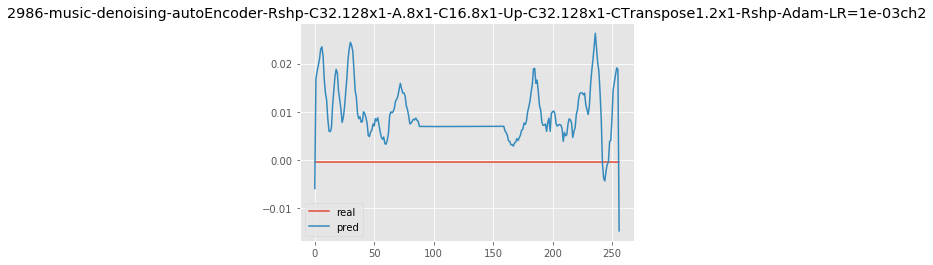

Done making training/test-sets, shapes:  (2300, 257, 14) (2300, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 51.3 +/- 2.13 %
mcc:         0.04 +/- 0.07


network: 2988-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 51.35 +/- 3.8 %
mcc:         0.03 +/- 0.08


network: 2989-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.33 +/- 1.92 %
mcc:         -0.01 +/- 0.04


network: 2990-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.63 +/- 3.23 %
mcc:         0.03 +/- 0.06


network: 2991-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.65 +/- 4.07 %
mcc:      

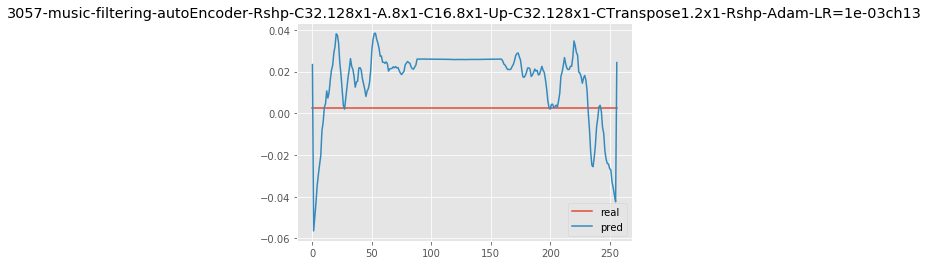

xTrain.shape: (2300, 257, 14)
filtering channels: [0, 3, 5]
filtering examples: [365, 1565]
Train examples: 2298 ratio: 50.0 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 50.69 +/- 3.19 %
mcc:         0.04 +/- 0.07


network: 3059-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.94 +/- 2.54 %
mcc:         -0.0 +/- 0.05


network: 3060-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.0 +/- 2.08 %
mcc:         -0.02 +/- 0.04


network: 3061-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 48.83 +/- 2.23 %
mcc:         -0.02 +/- 0.04


network: 3062-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2

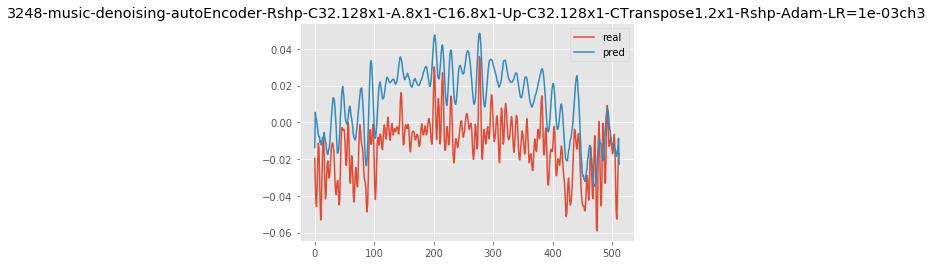

Done making training/test-sets, shapes:  (1150, 513, 14) (1150, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 51.39 +/- 1.57 %
mcc:         0.04 +/- 0.05


network: 3250-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 51.36 +/- 3.62 %
mcc:         0.03 +/- 0.07


network: 3251-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 48.74 +/- 4.75 %
mcc:         -0.03 +/- 0.1


network: 3252-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.74 +/- 2.69 %
mcc:         -0.01 +/- 0.05


network: 3253-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
scor

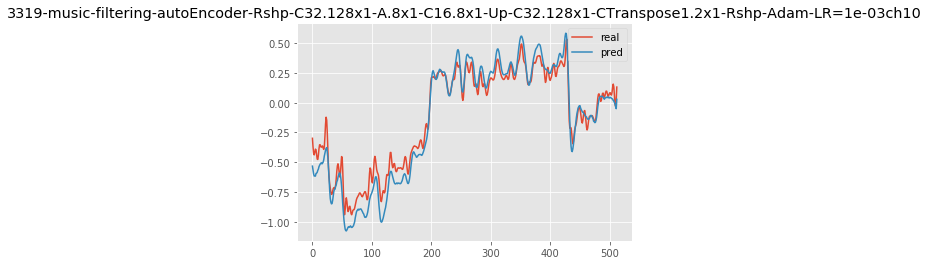

xTrain.shape: (1150, 513, 14)
filtering channels: [0, 3, 5]
filtering examples: [125, 507, 868]
Train examples: 1147 ratio: 50.0 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 50.31 +/- 5.19 %
mcc:         0.02 +/- 0.06


network: 3321-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.0 +/- 0.0 %
mcc:         0.0 +/- 0.0


network: 3322-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.07 +/- 5.16 %
mcc:         -0.02 +/- 0.1


network: 3323-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.42 +/- 4.66 %
mcc:         -0.01 +/- 0.09


network: 3324-music-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-C32.16-A.3-C32.16-A.3

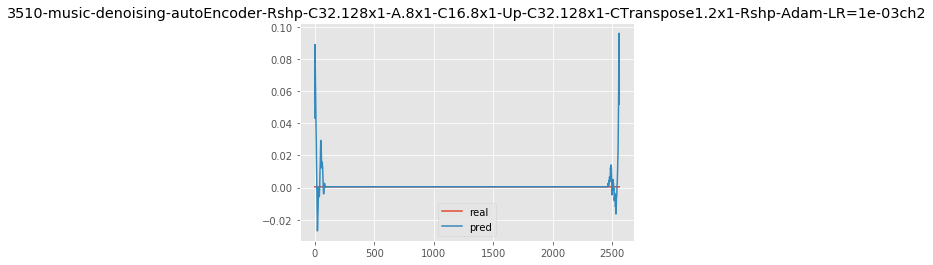

Done making training/test-sets, shapes:  (230, 2561, 14) (230, 2) (0, 2561, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 51.44 +/- 6.44 %
mcc:         0.02 +/- 0.19


network: 3512-music-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 48.31 +/- 10.95 %
mcc:         -0.03 +/- 0.22


network: 3513-music-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 48.11 +/- 7.02 %
mcc:         -0.04 +/- 0.14


network: 3514-music-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 53.58 +/- 8.63 %
mcc:         0.07 +/- 0.17


network: 3515-music-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-F

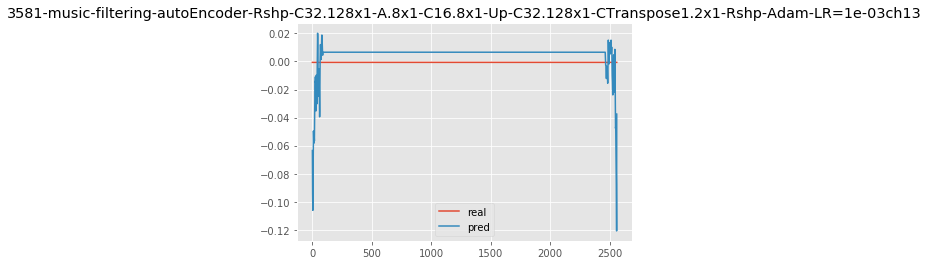

xTrain.shape: (230, 2561, 14)
filtering channels: [0, 3, 5]
filtering examples: [77, 110]
Train examples: 228 ratio: 50.0 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7


RuntimeError: Can't decrement id ref count (unable to extend file properly)

In [128]:
experiments = ['music', 'beeps', 'light'] 
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise1e-4-', preprocessing = True, ICA = True, noiseValue = 1e-4, onlyOneFold = False)
print('done')

Enabling CUDA with 2.36 GB available memory
last event at time:  603631.0
Done making training/test-sets, shapes:  (207, 2561, 14) (207, 2) (23, 2561, 14) (23, 2)
Done making training/test-sets, shapes:  (230, 2561, 14) (230, 2) (0, 2561, 14) (0, 2)
filtering with auto encoder
Done making training/test-sets, shapes:  (4363, 2561, 14) (4363, 1) (485, 2561, 14) (485, 1)
4363 train samples
485 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2561, 14, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2561, 14, 32)      4128      
_________________________________________________________________
average_pooling2d (AveragePo (None, 320, 14, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 14, 16)       4112      

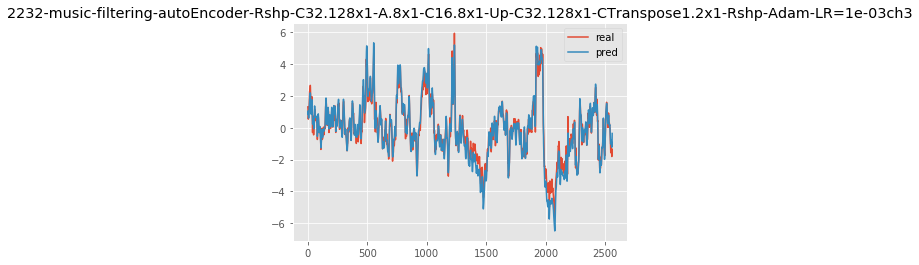

xTrain.shape: (230, 2561, 14)
filtering channels: [0, 3, 5]
filtering examples: [50, 216]
Train examples: 228 ratio: 50.0 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 51.93 +/- 6.86 %
mcc:         0.06 +/- 0.12


network: 2234-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax10-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.42 +/- 1.25 %
mcc:         0.01 +/- 0.02


network: 2235-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax10-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.0 +/- 5.51 %
mcc:         0.0 +/- 0.11


network: 2236-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax10-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 50.53 +/- 5.56 %
mcc:         0.01 +/- 0.11


network: 2237-music-CQ-Norm-ICA-noise1e-4-tmin-0-tmax10-filteredWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-A

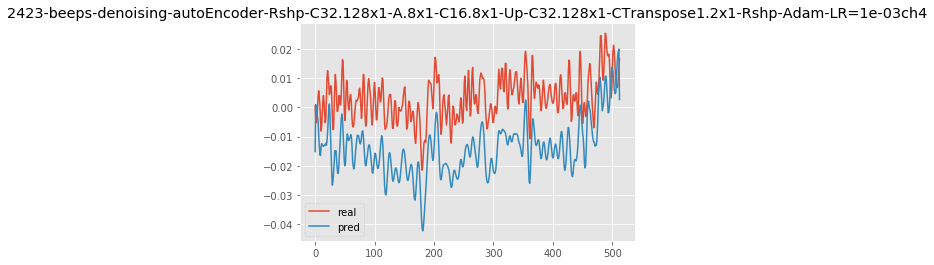

Done making training/test-sets, shapes:  (400, 513, 14) (400, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-beeps
score: 48.75 +/- 4.91 %
mcc:         -0.06 +/- 0.14


network: 2425-beeps-CQ-Norm-ICA-noise1e-4-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.25 +/- 4.67 %
mcc:         0.0 +/- 0.09


network: 2426-beeps-CQ-Norm-ICA-noise1e-4-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.25 +/- 6.44 %
mcc:         0.0 +/- 0.13


network: 2427-beeps-CQ-Norm-ICA-noise1e-4-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.25 +/- 7.96 %
mcc:         0.03 +/- 0.16


network: 2428-beeps-CQ-Norm-ICA-noise1e-4-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 50.62 +/- 7.73 %
mcc:         0.01 +/- 0.15


network: 2429-beeps-CQ-No

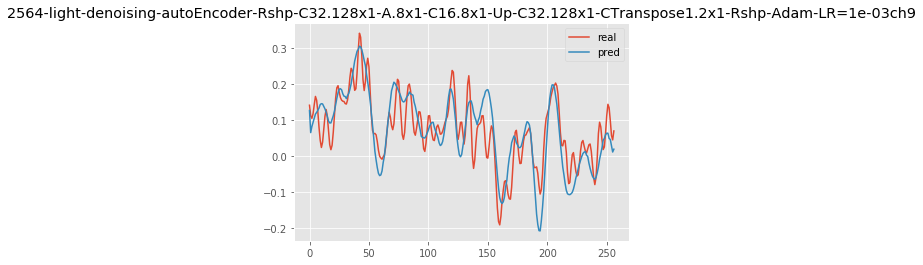

Done making training/test-sets, shapes:  (995, 257, 14) (995, 2) (0, 257, 14) (1305, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 48.33 +/- 2.81 %
mcc:         -0.0 +/- 0.11


network: 2566-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 47.59 +/- 3.83 %
mcc:         -0.05 +/- 0.08


network: 2567-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 47.73 +/- 4.07 %
mcc:         -0.05 +/- 0.08


network: 2568-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 47.84 +/- 4.93 %
mcc:         -0.04 +/- 0.1


network: 2569-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.88 +/- 4.26 %
mcc:  

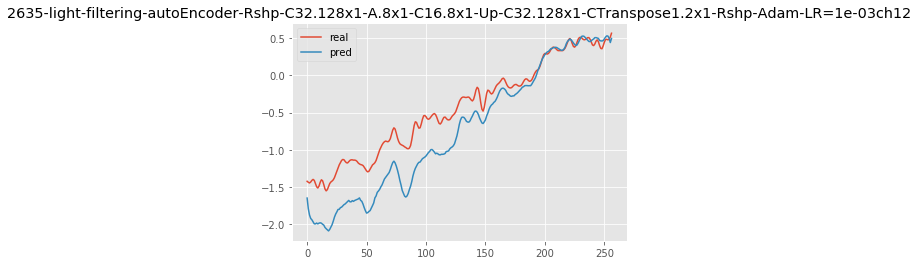

xTrain.shape: (995, 257, 14)
filtering channels: [0, 3, 5]
filtering examples: [65, 120, 161, 169, 198, 295, 387, 421, 463, 495, 501, 502, 531, 578, 621, 688, 709, 735, 961, 985]
Train examples: 975 ratio: 51.5 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 49.24 +/- 3.45 %
mcc:         -0.03 +/- 0.06


network: 2637-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.97 +/- 4.83 %
mcc:         0.02 +/- 0.1


network: 2638-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.42 +/- 3.94 %
mcc:         0.01 +/- 0.08


network: 2639-light-CQ-Norm-ICA-noise1e-4-tmin-0-tmax1-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 50.71 +/- 3.65 %
mcc:         0.01 +/- 0.07


network: 2640-light-CQ-Norm-ICA-noise1e-4-t

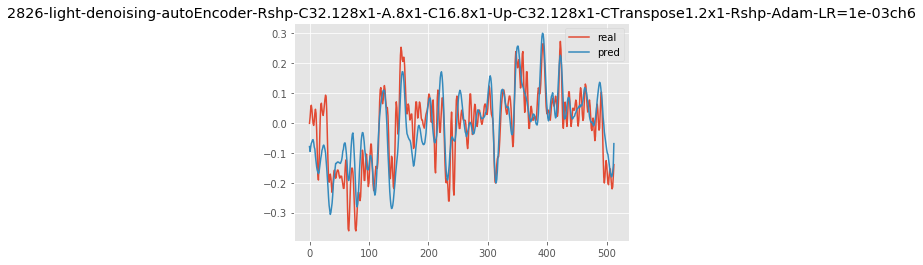

Done making training/test-sets, shapes:  (497, 513, 14) (497, 2) (0, 513, 14) (653, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 49.72 +/- 4.71 %
mcc:         -0.03 +/- 0.09


network: 2828-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.88 +/- 5.19 %
mcc:         -0.0 +/- 0.1


network: 2829-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 52.1 +/- 6.61 %
mcc:         0.04 +/- 0.13


network: 2830-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 54.74 +/- 5.54 %
mcc:         0.09 +/- 0.11


network: 2831-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score:

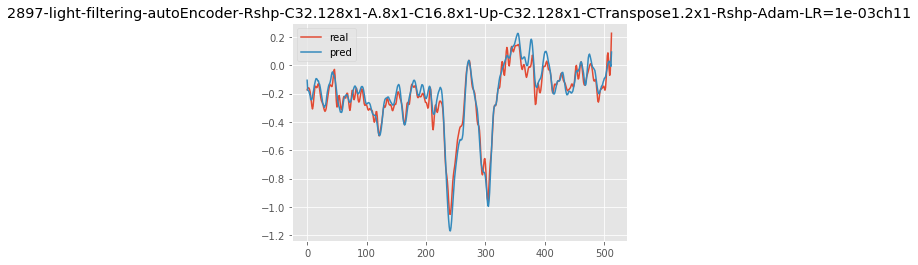

xTrain.shape: (497, 513, 14)
filtering channels: [0, 3, 5]
filtering examples: [17, 30, 89, 103, 123, 126, 151, 162, 324, 397, 475]
Train examples: 486 ratio: 52.5 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 50.83 +/- 7.04 %
mcc:         -0.06 +/- 0.14


network: 2899-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.2 +/- 2.57 %
mcc:         -0.02 +/- 0.05


network: 2900-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.28 +/- 1.71 %
mcc:         -0.01 +/- 0.03


network: 2901-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 47.56 +/- 3.71 %
mcc:         -0.05 +/- 0.07


network: 2902-light-CQ-Norm-ICA-noise1e-4-Fouriertmin-0-tmax2-filt

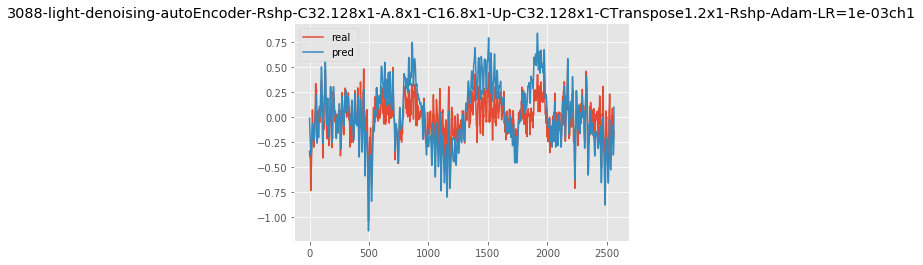

Done making training/test-sets, shapes:  (99, 2561, 14) (99, 2) (0, 2561, 14) (131, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 46.21 +/- 7.32 %
mcc:         -0.06 +/- 0.16


network: 3090-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.32 +/- 11.34 %
mcc:         0.05 +/- 0.23


network: 3091-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 53.03 +/- 8.21 %
mcc:         0.06 +/- 0.16


network: 3092-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 54.74 +/- 11.81 %
mcc:         0.09 +/- 0.24


network: 3093-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3-F

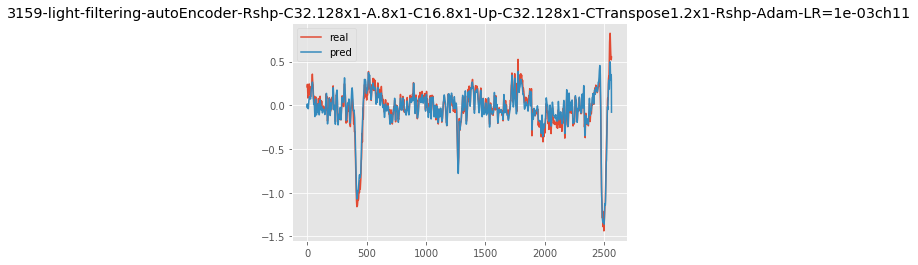

xTrain.shape: (99, 2561, 14)
filtering channels: [0, 3, 5]
filtering examples: [0, 19, 34, 35, 48, 63, 85]
Train examples: 92 ratio: 46.7 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 46.56 +/- 14.47 %
mcc:         -0.15 +/- 0.29


network: 3161-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 44.42 +/- 5.61 %
mcc:         -0.11 +/- 0.11


network: 3162-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 43.53 +/- 7.39 %
mcc:         -0.13 +/- 0.15


network: 3163-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax10-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 50.89 +/- 5.04 %
mcc:         0.02 +/- 0.1


network: 3164-light-CQ-Norm-ICA-noise1e-4-FourierFouriertmin-0-tmax1

In [16]:
experiments = ['music', 'beeps', 'light'] 
for experiment in experiments:
    main(experiment, plot = False, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise1e-4-', preprocessing = True, ICA = True, noiseValue = 1e-4, onlyOneFold = False, skip = True)
print('done')

last event at time:  265475.0
Done making training/test-sets, shapes:  (804, 257, 14) (804, 2) (90, 257, 14) (90, 2)


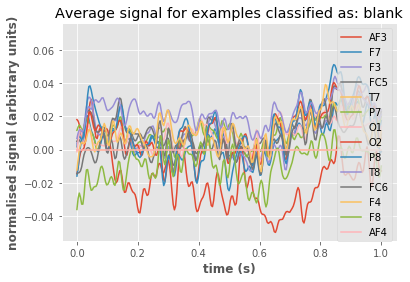

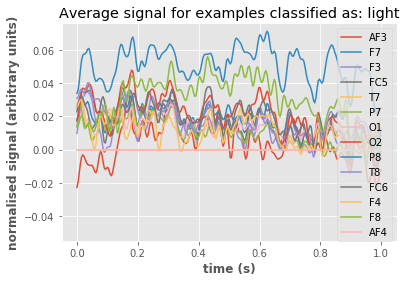

Done making training/test-sets, shapes:  (894, 257, 14) (894, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 47.88 +/- 3.55 %
mcc:         -0.06 +/- 0.1


network: 2574-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 54.99 +/- 3.71 %
mcc:         0.1 +/- 0.07


network: 2575-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 56.36 +/- 5.73 %
mcc:         0.13 +/- 0.11


network: 2576-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 48.66 +/- 4.32 %
mcc:         -0.03 +/- 0.09


network: 2577-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.48 +/- 4.28 %
mcc:         0.03 +/- 0.09


networ

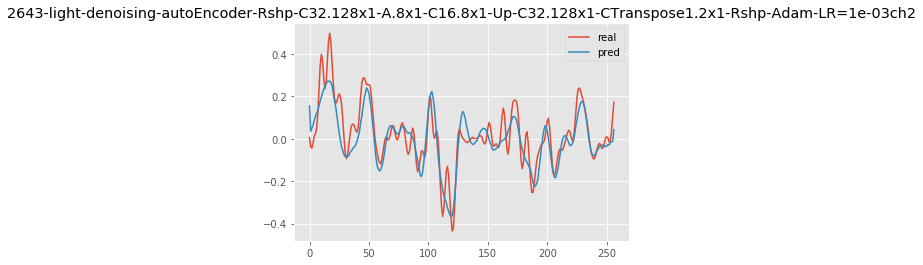

Done making training/test-sets, shapes:  (894, 257, 14) (894, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 48.34 +/- 4.0 %
mcc:         -0.06 +/- 0.12


network: 2645-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 54.65 +/- 5.12 %
mcc:         0.09 +/- 0.1


network: 2646-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 54.17 +/- 3.98 %
mcc:         0.08 +/- 0.08


network: 2647-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.89 +/- 6.06 %
mcc:         0.04 +/- 0.12


network: 2648-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.3

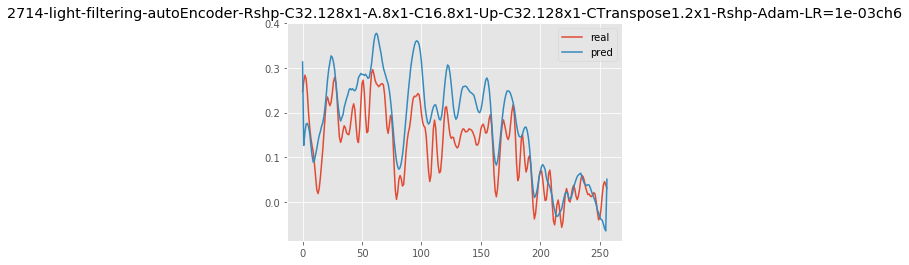

xTrain.shape: (894, 257, 14)
filtering channels: [0, 3, 5]
filtering examples: [153, 196, 320, 457, 458, 724]
Train examples: 888 ratio: 49.9 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 52.03 +/- 4.31 %
mcc:         0.04 +/- 0.05


network: 2716-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.84 +/- 2.24 %
mcc:         -0.0 +/- 0.04


network: 2717-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.81 +/- 3.28 %
mcc:         0.02 +/- 0.07


network: 2718-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.77 +/- 4.91 %
mcc:         0.04 +/- 0.1


network: 2719-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmi

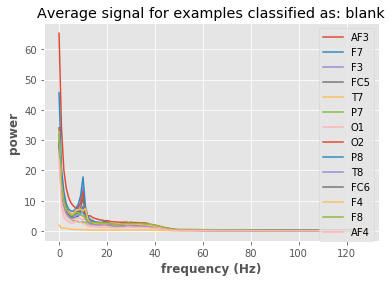

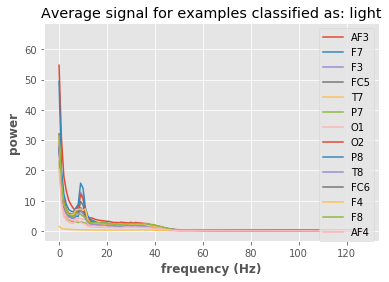

Done making training/test-sets, shapes:  (894, 128, 14) (894, 2) (0, 128, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 51.34 +/- 1.81 %
mcc:         0.04 +/- 0.05


network: 2786-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 58.22 +/- 2.68 %
mcc:         0.16 +/- 0.05


network: 2787-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 51.59 +/- 4.82 %
mcc:         0.03 +/- 0.1


network: 2788-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 54.66 +/- 7.36 %
mcc:         0.09 +/- 0.15


network: 2789-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 54.14 +/- 5.38 %
mcc:         0.08 +/- 0.11


last event at time: 

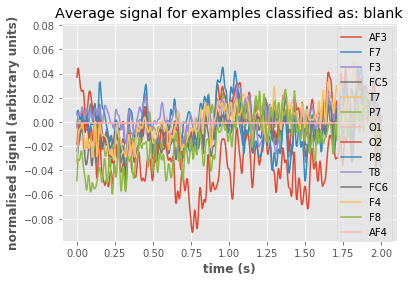

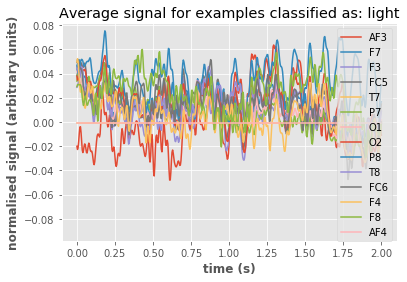

Done making training/test-sets, shapes:  (427, 513, 14) (427, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 50.39 +/- 5.92 %
mcc:         -0.0 +/- 0.15


network: 2836-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 53.16 +/- 7.51 %
mcc:         0.06 +/- 0.15


network: 2837-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 56.01 +/- 5.17 %
mcc:         0.12 +/- 0.1


network: 2838-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.76 +/- 9.43 %
mcc:         0.04 +/- 0.19


network: 2839-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.09 +/- 7.38 %
mcc:    

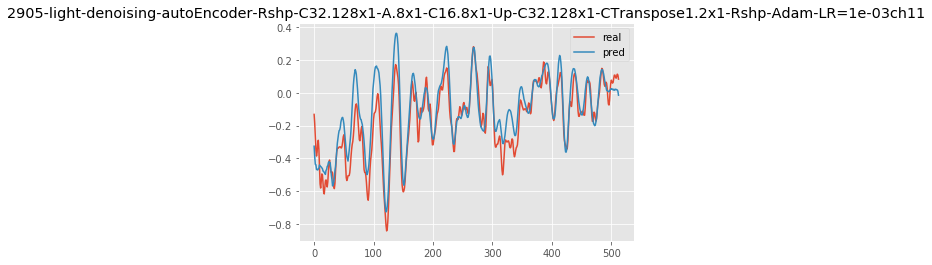

Done making training/test-sets, shapes:  (427, 513, 14) (427, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 47.74 +/- 6.06 %
mcc:         -0.07 +/- 0.16


network: 2907-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.36 +/- 5.46 %
mcc:         0.05 +/- 0.11


network: 2908-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 52.06 +/- 8.3 %
mcc:         0.04 +/- 0.17


network: 2909-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 53.28 +/- 6.24 %
mcc:         0.07 +/- 0.12


network: 2910-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-denoisedWithAutoencoder-C32

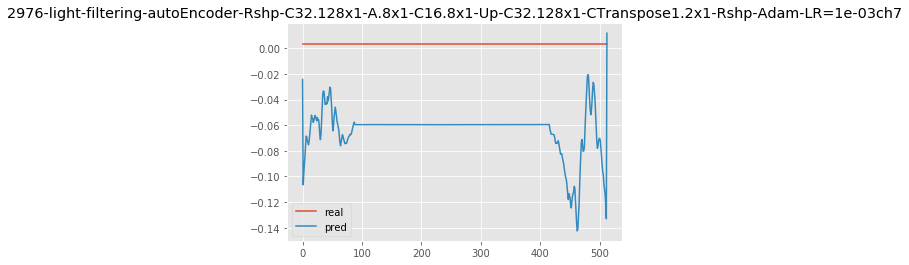

xTrain.shape: (427, 513, 14)
filtering channels: [0, 3, 5]
filtering examples: [255, 321]
Train examples: 425 ratio: 49.9 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 49.87 +/- 4.65 %
mcc:         -0.02 +/- 0.12


network: 2978-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.77 +/- 3.9 %
mcc:         -0.0 +/- 0.08


network: 2979-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 48.95 +/- 3.19 %
mcc:         -0.02 +/- 0.06


network: 2980-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.65 +/- 3.74 %
mcc:         -0.01 +/- 0.07


network: 2981-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-

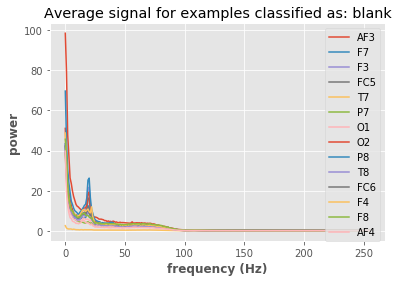

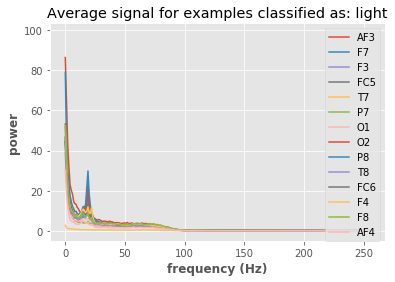

Done making training/test-sets, shapes:  (427, 256, 14) (427, 2) (0, 256, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 51.73 +/- 5.34 %
mcc:         0.05 +/- 0.15


network: 3048-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 60.76 +/- 5.65 %
mcc:         0.22 +/- 0.11


network: 3049-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.0 +/- 0.53 %
mcc:         -0.01 +/- 0.03


network: 3050-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 60.83 +/- 5.67 %
mcc:         0.22 +/- 0.11


network: 3051-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3Fouriertmin-0-tmax2-Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 55.9 +/- 9.21 %
mcc:         0.12 +/-

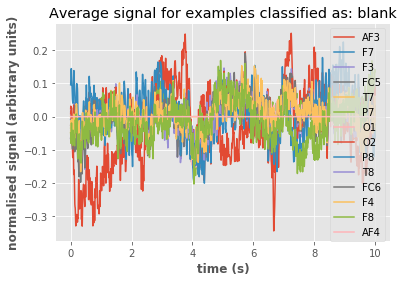

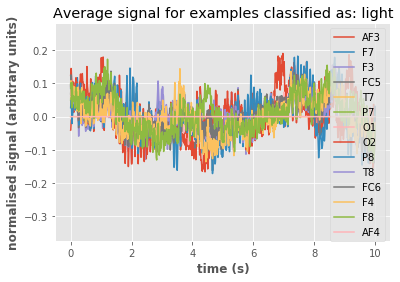

Done making training/test-sets, shapes:  (65, 2561, 14) (65, 2) (0, 2561, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 64.7 +/- 19.16 %
mcc:         0.31 +/- 0.42


network: 3098-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 63.75 +/- 13.28 %
mcc:         0.28 +/- 0.27


network: 3099-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 63.63 +/- 11.25 %
mcc:         0.27 +/- 0.22


network: 3100-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 61.04 +/- 16.46 %
mcc:         0.22 +/- 0.33


network: 3101-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e

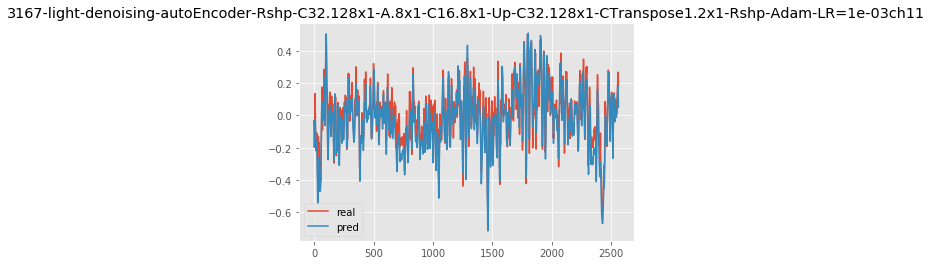

Done making training/test-sets, shapes:  (65, 2561, 14) (65, 2) (0, 2561, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 59.94 +/- 20.35 %
mcc:         0.22 +/- 0.44


network: 3169-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 55.69 +/- 19.53 %
mcc:         0.12 +/- 0.39


network: 3170-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 64.26 +/- 11.34 %
mcc:         0.29 +/- 0.23


network: 3171-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.49 +/- 16.64 %
mcc:         0.03 +/- 0.34


network: 3172-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-

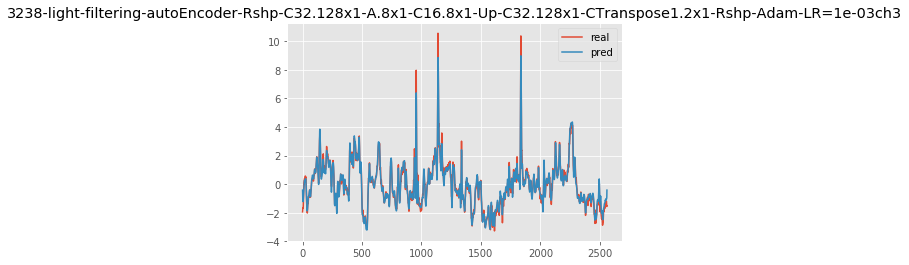

xTrain.shape: (65, 2561, 14)
filtering channels: [0, 3, 5]
filtering examples: [55]
Train examples: 64 ratio: 48.4 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 52.92 +/- 17.13 %
mcc:         0.06 +/- 0.39


network: 3240-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.38 +/- 5.22 %
mcc:         0.05 +/- 0.1


network: 3241-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 54.05 +/- 6.66 %
mcc:         0.08 +/- 0.13


network: 3242-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3FourierFouriertmin-0-tmax10-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.29 +/- 2.14 %
mcc:         -0.01 +/- 0.04


network: 3243-light-CQ-Norm-ICA-noise3e-4-

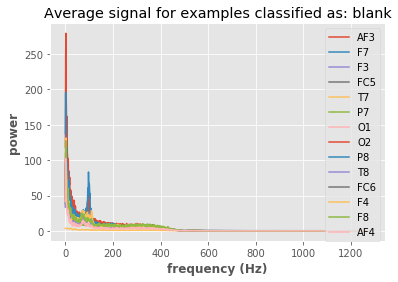

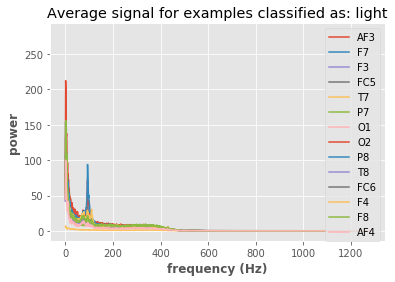

Done making training/test-sets, shapes:  (65, 1280, 14) (65, 2) (0, 1280, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3


In [ ]:
experiments = ['light', 'music', 'beeps', 'moveHandsBig']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3',
         preprocessing = True, ICA = True, noiseValue = 3e-4, onlyOneFold = False, skip = False, patience = 15)
print('done')

last event at time:  265475.0
Done making training/test-sets, shapes:  (58, 2561, 14) (58, 2) (7, 2561, 14) (7, 2)


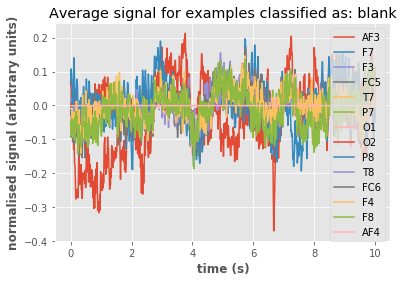

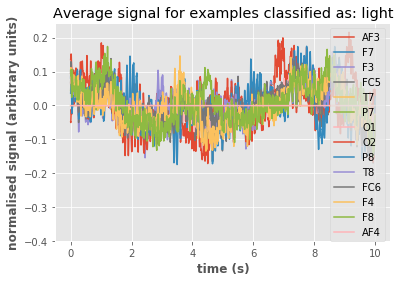

Done making training/test-sets, shapes:  (65, 2561, 14) (65, 2) (0, 2561, 14) (0, 2)
Done making training/test-sets, shapes:  (58, 256, 14) (58, 2) (7, 256, 14) (7, 2)


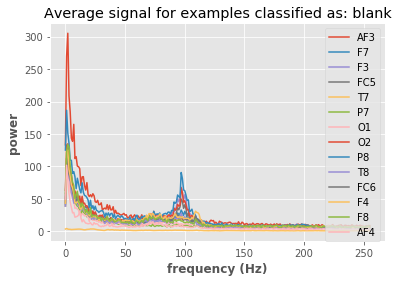

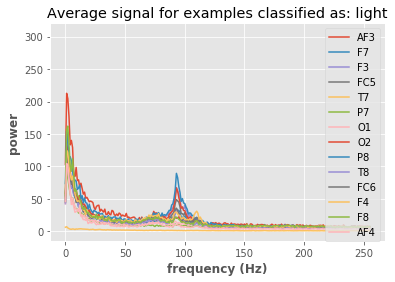

Done making training/test-sets, shapes:  (65, 256, 14) (65, 2) (0, 256, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-light
score: 64.23 +/- 15.3 %
mcc:         0.3 +/- 0.32


network: 4104-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 59.88 +/- 12.27 %
mcc:         0.21 +/- 0.25


network: 4105-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.0 +/- 0.0 %
mcc:         0.0 +/- 0.0


network: 4106-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 61.73 +/- 13.71 %
mcc:         0.23 +/- 0.28


network: 4107-light-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 56.58 +/- 16.99 %
mcc:         0.13 +/- 0.34




OutOfMemoryError: out of memory to allocate 524800 bytes (total 2098176 bytes)

In [26]:
experiments = ['light', 'music', 'beeps', 'moveHandsBig']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3',
         preprocessing = True, ICA = True, noiseValue = 3e-4, onlyOneFold = False, skip = True, patience = 15)
print('done')

Enabling CUDA with 2.36 GB available memory
last event at time:  603631.0
Done making training/test-sets, shapes:  (520, 257, 14) (520, 2) (58, 257, 14) (58, 2)


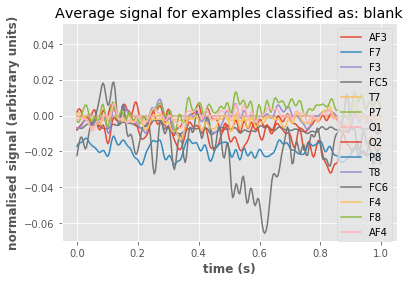

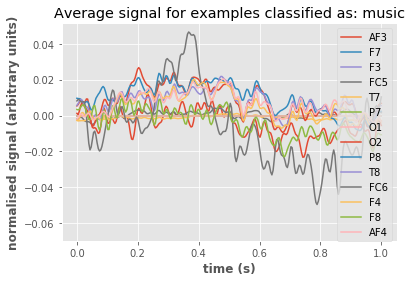

Done making training/test-sets, shapes:  (578, 257, 14) (578, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 47.39 +/- 5.71 %
mcc:         -0.05 +/- 0.13


network: 4001-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 51.13 +/- 3.76 %
mcc:         0.02 +/- 0.08


network: 4002-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.25 +/- 4.4 %
mcc:         0.01 +/- 0.09


network: 4003-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.72 +/- 4.27 %
mcc:         0.03 +/- 0.09


network: 4004-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.2 +/- 6.84 %
mcc:         0.02 +/- 0.14


network

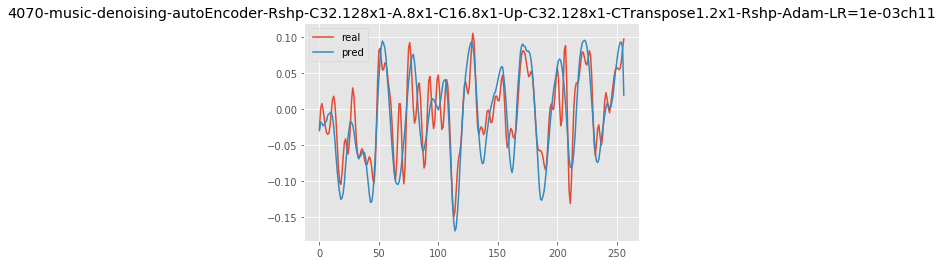

Done making training/test-sets, shapes:  (578, 257, 14) (578, 2) (0, 257, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 47.9 +/- 6.53 %
mcc:         -0.04 +/- 0.15


network: 4072-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 51.99 +/- 5.36 %
mcc:         0.04 +/- 0.11


network: 4073-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 52.51 +/- 6.05 %
mcc:         0.05 +/- 0.12


network: 4074-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.38 +/- 4.12 %
mcc:         0.03 +/- 0.08


network: 4075-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.16-A.

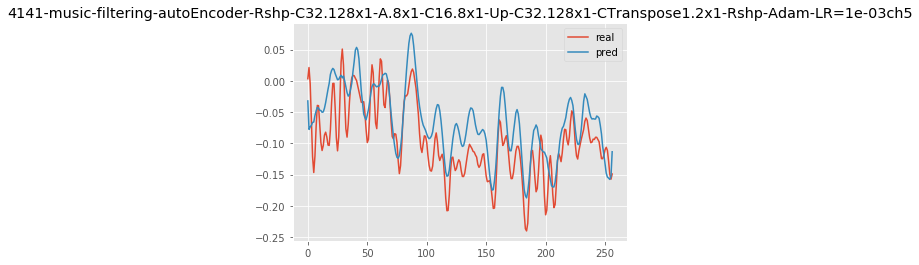

xTrain.shape: (578, 257, 14)
filtering channels: [0, 3, 5]
filtering examples: []
Train examples: 578 ratio: 51.2 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 47.91 +/- 3.68 %
mcc:         -0.06 +/- 0.09


network: 4143-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.83 +/- 0.93 %
mcc:         -0.0 +/- 0.02


network: 4144-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.49 +/- 0.88 %
mcc:         -0.01 +/- 0.02


network: 4145-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 50.09 +/- 0.81 %
mcc:         0.0 +/- 0.02


network: 4146-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-filteredWithAuto

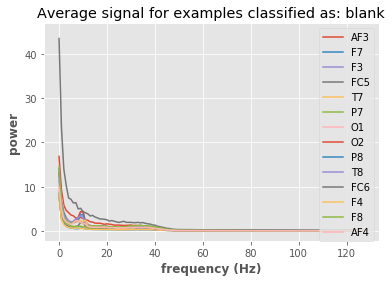

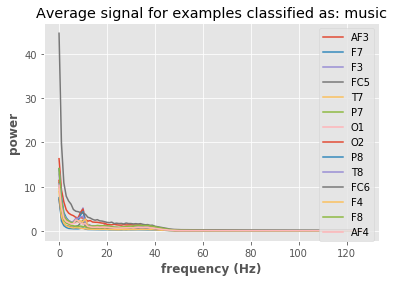

Done making training/test-sets, shapes:  (578, 128, 14) (578, 2) (0, 128, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 50.33 +/- 4.84 %
mcc:         0.01 +/- 0.1


network: 4213-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 55.28 +/- 5.44 %
mcc:         0.11 +/- 0.11


network: 4214-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 55.32 +/- 5.87 %
mcc:         0.11 +/- 0.12


network: 4215-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 56.66 +/- 3.72 %
mcc:         0.13 +/- 0.07


network: 4216-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax1-Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 55.21 +/- 4.69 %
mcc:         0.1 +/- 0.09


last event at time:  

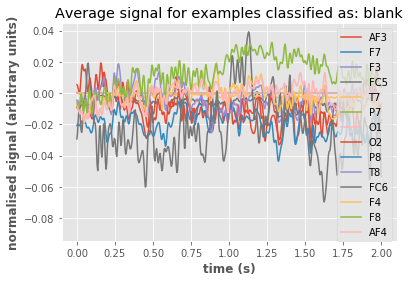

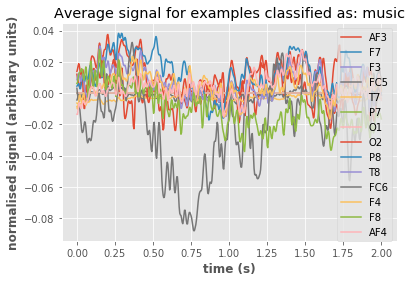

Done making training/test-sets, shapes:  (219, 513, 14) (219, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 44.61 +/- 8.77 %
mcc:         -0.11 +/- 0.2


network: 4263-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 49.14 +/- 5.42 %
mcc:         -0.02 +/- 0.11


network: 4264-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.44 +/- 8.65 %
mcc:         0.01 +/- 0.17


network: 4265-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 44.75 +/- 10.28 %
mcc:         -0.11 +/- 0.21


network: 4266-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 45.44 +/- 10.31 %
mcc:         -0.09 +/- 0.21


n

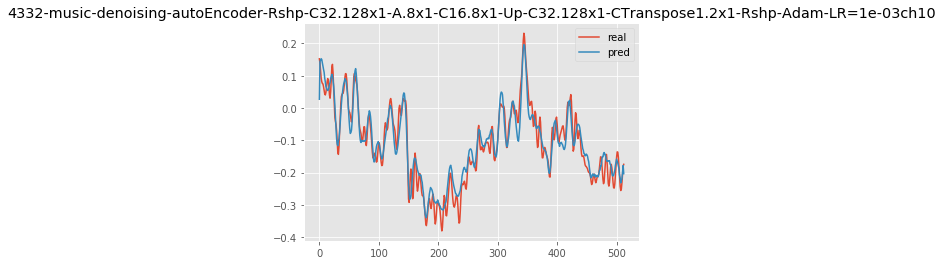

Done making training/test-sets, shapes:  (219, 513, 14) (219, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 44.07 +/- 11.11 %
mcc:         -0.12 +/- 0.25


network: 4334-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 48.26 +/- 8.34 %
mcc:         -0.03 +/- 0.17


network: 4335-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.28 +/- 4.71 %
mcc:         0.01 +/- 0.09


network: 4336-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.23 +/- 13.37 %
mcc:         0.02 +/- 0.27


network: 4337-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-C32.1

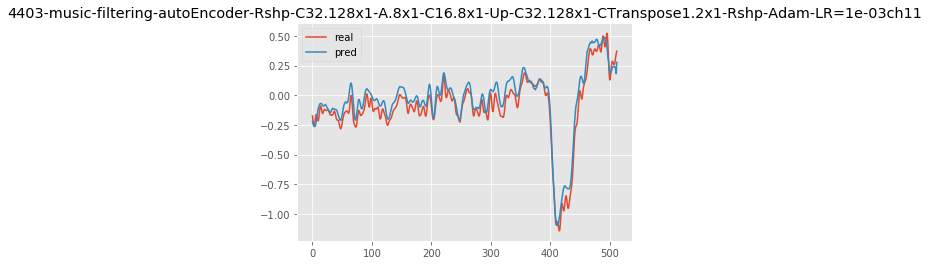

xTrain.shape: (219, 513, 14)
filtering channels: [0, 3, 5]
filtering examples: []
Train examples: 219 ratio: 51.6 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 42.89 +/- 4.46 %
mcc:         -0.18 +/- 0.1


network: 4405-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.46 +/- 0.91 %
mcc:         0.01 +/- 0.02


network: 4406-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.09 +/- 1.12 %
mcc:         -0.02 +/- 0.02


network: 4407-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.55 +/- 0.91 %
mcc:         -0.01 +/- 0.02


network: 4408-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-filteredWithAut

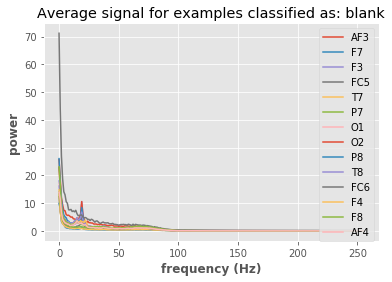

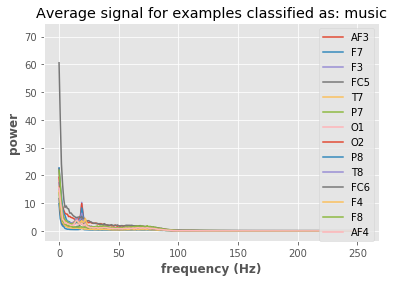

Done making training/test-sets, shapes:  (219, 256, 14) (219, 2) (0, 256, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 49.64 +/- 9.69 %
mcc:         0.02 +/- 0.24


network: 4475-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.84 +/- 8.22 %
mcc:         0.02 +/- 0.17


network: 4476-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 51.74 +/- 8.34 %
mcc:         0.03 +/- 0.18


network: 4477-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 52.63 +/- 10.47 %
mcc:         0.05 +/- 0.21


network: 4478-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax2-Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 54.96 +/- 13.75 %
mcc:         0.1 +/- 0.28


last event at time

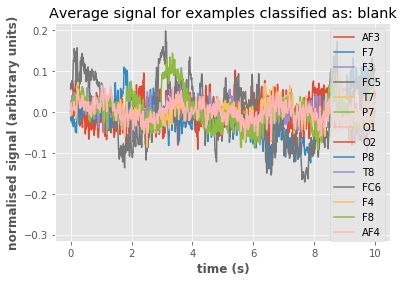

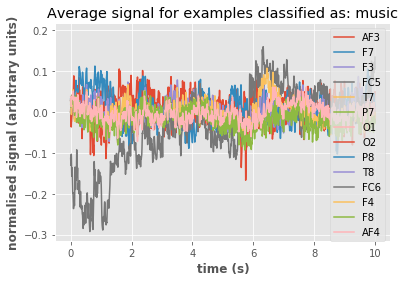

Done making training/test-sets, shapes:  (24, 2561, 14) (24, 2) (0, 2561, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 38.33 +/- 25.87 %
mcc:         -0.3 +/- 0.46


network: 4525-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10--Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 37.92 +/- 26.64 %
mcc:         -0.26 +/- 0.55


network: 4526-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10--Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 45.83 +/- 33.18 %
mcc:         -0.08 +/- 0.67


network: 4527-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10--C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 46.67 +/- 27.69 %
mcc:         -0.07 +/- 0.55


network: 4528-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10--C32.16-A.3-C32.16-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.25 +/- 27.52 %
mcc:         0.02 +/- 0

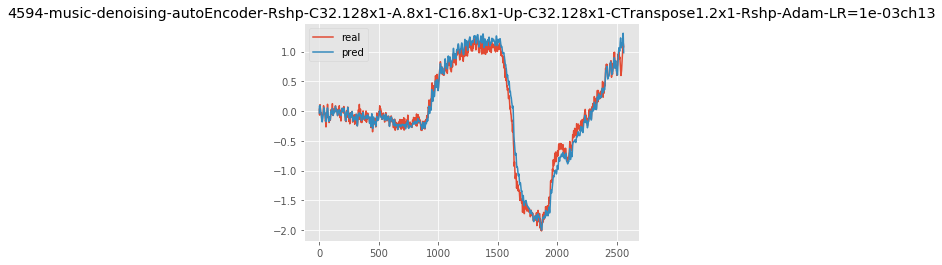

Done making training/test-sets, shapes:  (24, 2561, 14) (24, 2) (0, 2561, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 40.0 +/- 21.34 %
mcc:         -0.25 +/- 0.4


network: 4596-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 38.33 +/- 34.2 %
mcc:         -0.23 +/- 0.68


network: 4597-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 34.17 +/- 28.98 %
mcc:         -0.32 +/- 0.58


network: 4598-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 41.25 +/- 31.54 %
mcc:         -0.17 +/- 0.63


network: 4599-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-denoisedWithAutoencoder-C32.16-A.3-C32.16-A.3-

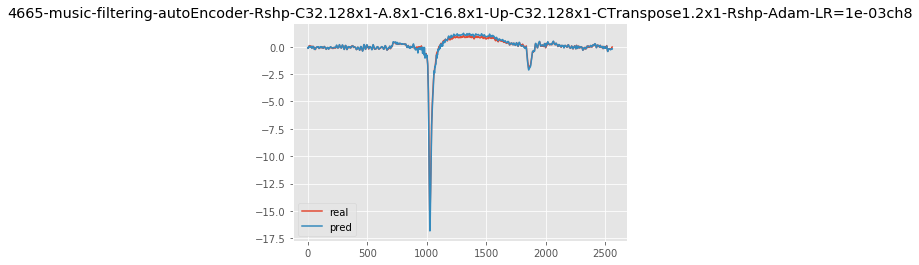

xTrain.shape: (24, 2561, 14)
filtering channels: [0, 3, 5]
filtering examples: []
Train examples: 24 ratio: 45.8 % blanks
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 28.33 +/- 23.63 %
mcc:         -0.45 +/- 0.47


network: 4667-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-filteredWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 48.33 +/- 5.0 %
mcc:         -0.03 +/- 0.1


network: 4668-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-filteredWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 53.33 +/- 6.67 %
mcc:         0.07 +/- 0.13


network: 4669-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-filteredWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 48.33 +/- 5.0 %
mcc:         -0.03 +/- 0.1


network: 4670-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-filteredWithAu

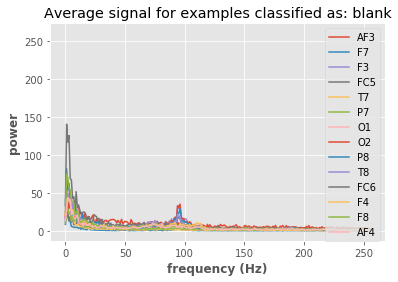

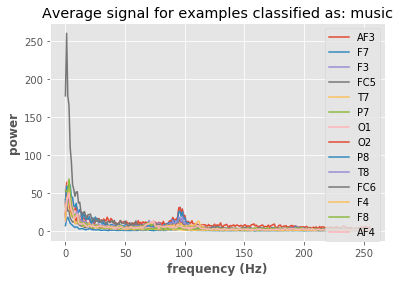

Done making training/test-sets, shapes:  (24, 256, 14) (24, 2) (0, 256, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-music
score: 48.33 +/- 17.4 %
mcc:         -0.05 +/- 0.35


network: 4737-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.08 +/- 20.85 %
mcc:         0.04 +/- 0.47


network: 4738-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 48.75 +/- 8.75 %
mcc:         -0.02 +/- 0.22


network: 4739-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 51.67 +/- 32.02 %
mcc:         0.03 +/- 0.64


network: 4740-music-CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3tmin-0-tmax10-Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 63.33 +/- 19.44 %
mcc:         0.27 +/- 0.39


last event a

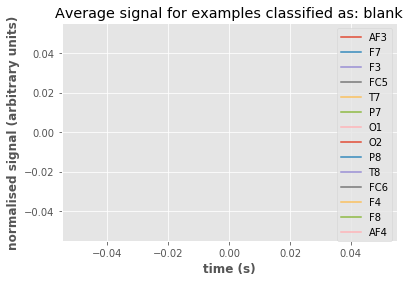

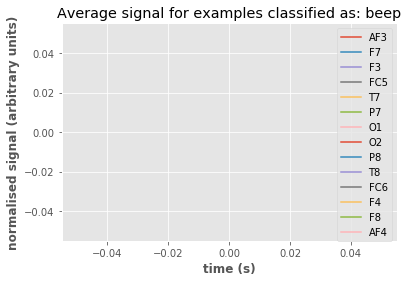

Done making training/test-sets, shapes:  (0, 513, 14) (0, 2) (0, 513, 14) (0, 2)


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [16]:
experiments = ['music', 'beeps', 'moveHandsBig']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise3e-4-Patience15-LR1e-3',
         preprocessing = True, ICA = True, noiseValue = 3e-4, onlyOneFold = False, skip = False, patience = 15)
print('done')

last event at time:  209662.0
Done making training/test-sets, shapes:  (338, 513, 14) (338, 2) (38, 513, 14) (38, 2)


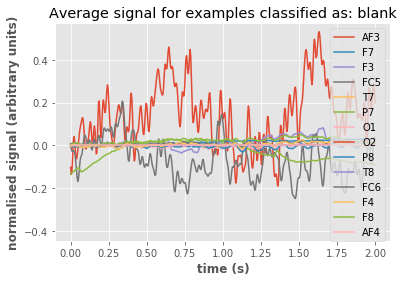

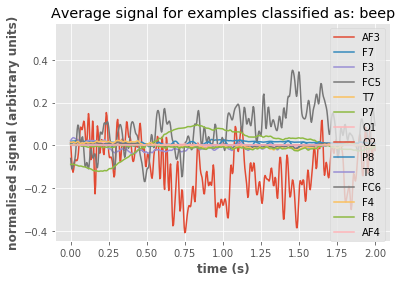

Done making training/test-sets, shapes:  (376, 513, 14) (376, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-beeps
score: 48.86 +/- 5.29 %
mcc:         -0.03 +/- 0.15


network: 4787-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.16 +/- 5.14 %
mcc:         0.04 +/- 0.1


network: 4788-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.28 +/- 7.06 %
mcc:         0.01 +/- 0.14


network: 4789-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 53.52 +/- 8.7 %
mcc:         0.07 +/- 0.17


network: 4790-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.65 +/- 8.0 %
mcc:         -0.01 +/- 0.16


network: 4791-beeps-CQ-Norm-ICA-noise3e-3-Patienc

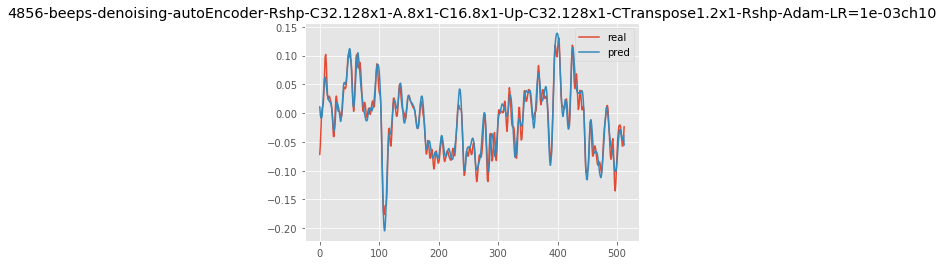

Done making training/test-sets, shapes:  (376, 513, 14) (376, 2) (0, 513, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-beeps
score: 49.14 +/- 5.12 %
mcc:         -0.02 +/- 0.14


network: 4858-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3denoisedWithAutoencoder-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.94 +/- 5.1 %
mcc:         0.06 +/- 0.1


network: 4859-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3denoisedWithAutoencoder-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 52.19 +/- 6.88 %
mcc:         0.04 +/- 0.14


network: 4860-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 54.06 +/- 7.86 %
mcc:         0.08 +/- 0.16


network: 4861-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3denoisedWithAutoencoder-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 47.

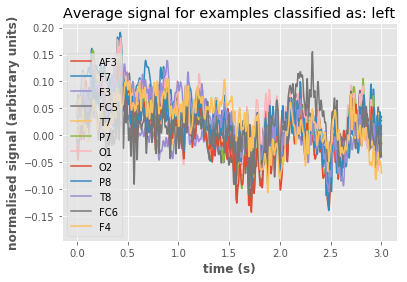

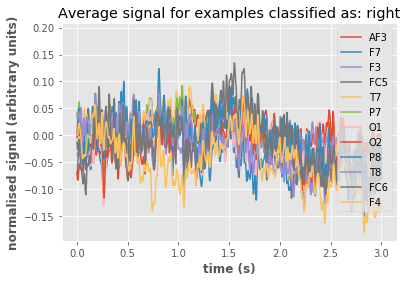

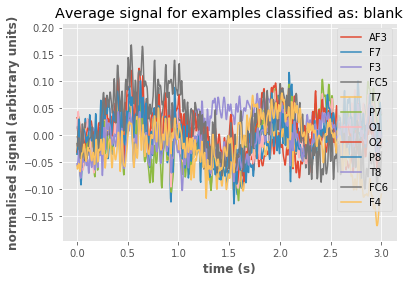

Done making training/test-sets, shapes:  (1486, 769, 12) (1486, 3) (0, 769, 12) (0, 3)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 29.88 +/- 2.41 %
mcc:         -0.06 +/- 0.04


network: 4928-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LRB-Fl-D32-DO=0-D16-DO=0-Fl-D3-Adam-LR=1e-03
score: 34.19 +/- 3.51 %
mcc:         0.02 +/- 0.03


network: 4929-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LRB-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D3-Adam-LR=1e-03
score: 33.65 +/- 0.11 %
mcc:         0.0 +/- 0.0


network: 4930-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LRB-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D3-Adam-LR=1e-03
score: 32.84 +/- 3.26 %
mcc:         0.02 +/- 0.03


network: 4931-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LRB-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D3-Adam-LR=1e-03
score: 33.91 +/- 2.48 %
mcc:         -0.01 +/- 0.03



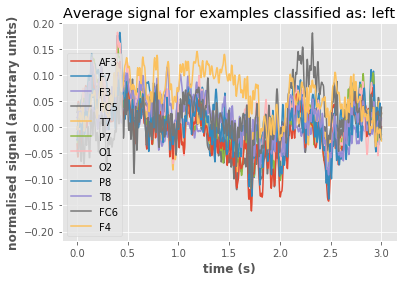

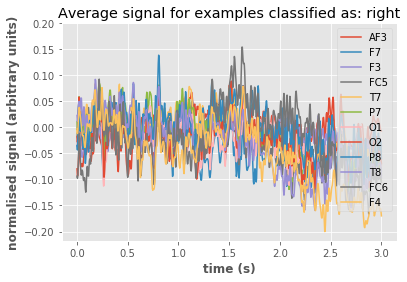

Done making training/test-sets, shapes:  (1000, 769, 12) (1000, 2) (0, 769, 12) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 50.1 +/- 4.74 %
mcc:         0.0 +/- 0.11


network: 4998-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LR-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 50.3 +/- 4.81 %
mcc:         0.01 +/- 0.1


network: 4999-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LR-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.7 +/- 4.46 %
mcc:         -0.01 +/- 0.09


network: 5000-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LR-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 49.55 +/- 4.34 %
mcc:         -0.01 +/- 0.09


network: 5001-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3LR-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 47.7 +/- 3.04 %
mcc:         -0.05 +/- 0.06


networ

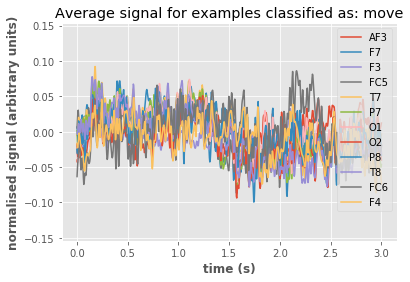

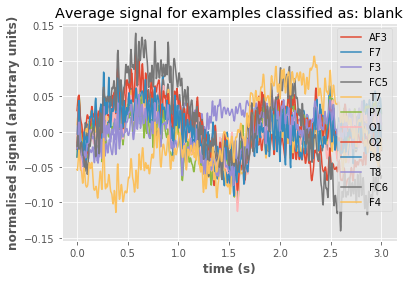

Done making training/test-sets, shapes:  (2000, 769, 12) (2000, 2) (0, 769, 12) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-moveHandsBig
score: 48.55 +/- 2.99 %
mcc:         -0.03 +/- 0.07


network: 5068-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-1e-3MB-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 51.05 +/- 3.3 %
mcc:         0.02 +/- 0.07


network: 5069-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-1e-3MB-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.05 +/- 1.91 %
mcc:         -0.02 +/- 0.04


network: 5070-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-1e-3MB-C8.64-A.3-C32.16-A.3-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 50.03 +/- 3.26 %
mcc:         0.0 +/- 0.07


network: 5071-moveHandsBig-CQ-Norm-ICA-noise3e-3-Patience15-1e-3MB-C8.64-A.3-C32.16-A.3-C32.16-A.1-C32.16-A.1-Fl-D64-D64-Fl-D2-Adam-LR=1e-03
score: 51.08 +/- 2.05 %
mcc:         0.02 +/- 0.04


network: 50

In [17]:
experiments = ['beeps', 'moveHandsBig']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3',
         preprocessing = True, ICA = True, noiseValue = 3e-3, onlyOneFold = False, skip = False, patience = 15)
print('done')

last event at time:  209662.0
Done making training/test-sets, shapes:  (338, 513, 14) (338, 2) (38, 513, 14) (38, 2)


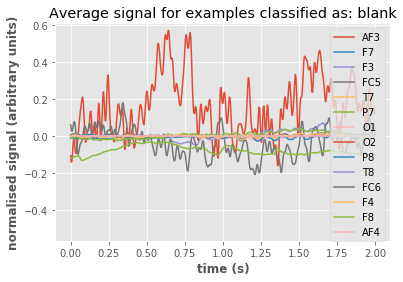

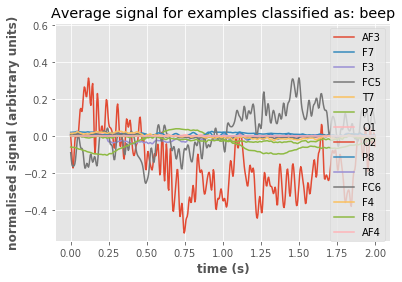

Done making training/test-sets, shapes:  (338, 128, 14) (338, 2) (38, 128, 14) (38, 2)


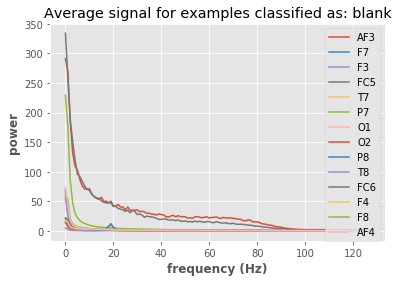

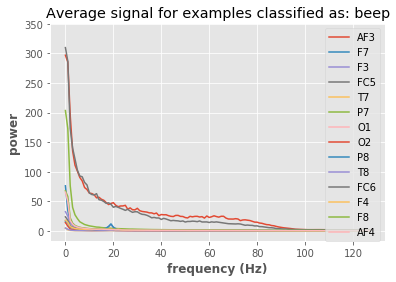

Done making training/test-sets, shapes:  (376, 128, 14) (376, 2) (0, 128, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-beeps
score: 48.13 +/- 3.94 %
mcc:         -0.05 +/- 0.1


network: 5138-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 44.9 +/- 6.18 %
mcc:         -0.11 +/- 0.12


network: 5139-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 49.87 +/- 0.4 %
mcc:         -0.0 +/- 0.01


network: 5140-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 46.67 +/- 5.13 %
mcc:         -0.07 +/- 0.1


network: 5141-beeps-CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 45.48 +/- 11.11 %
mcc:         -0.09 +/- 0.22


done


In [19]:
experiments = ['beeps']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm-ICA-noise3e-3-Patience15-LR1e-3',
         preprocessing = True, ICA = True, noiseValue = 3e-3, onlyOneFold = False, skip = True, patience = 15)
print('done')

last event at time:  209662.0
Done making training/test-sets, shapes:  (360, 513, 14) (360, 2) (40, 513, 14) (40, 2)


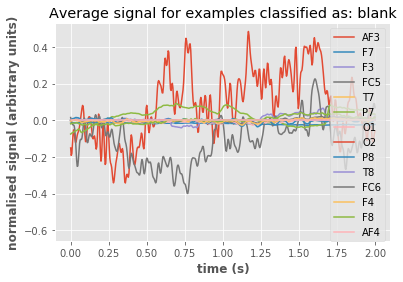

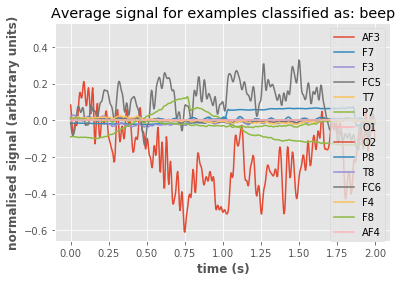

Done making training/test-sets, shapes:  (360, 128, 14) (360, 2) (40, 128, 14) (40, 2)


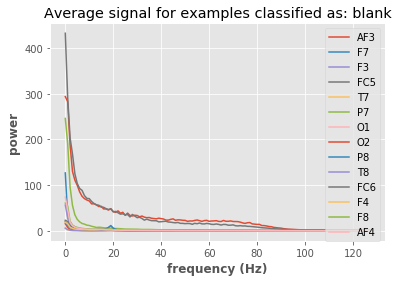

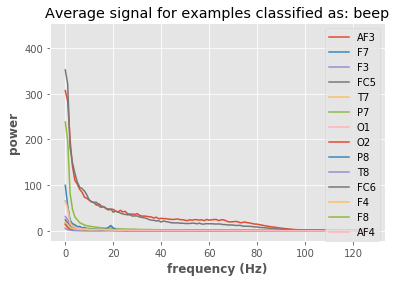

Done making training/test-sets, shapes:  (400, 128, 14) (400, 2) (0, 128, 14) (0, 2)
end fold 0
end fold 1
end fold 2
end fold 3
end fold 4
end fold 5
end fold 6
end fold 7
end fold 8
end fold 9
network: naiveBayes-beeps
score: 49.5 +/- 4.0 %
mcc:         0.0 +/- 0.14


network: 5188-beeps-CQ-Norm-ICA-Patience15-LR1e-3Fourier-Fl-D32-DO=0-D16-DO=0-Fl-D2-Adam-LR=1e-03
score: 52.12 +/- 3.49 %
mcc:         0.04 +/- 0.07


network: 5189-beeps-CQ-Norm-ICA-Patience15-LR1e-3Fourier-Fl-D1024-DO=0.3-D128-DO=0.3-D64-DO=0.3-Fl-D2-Adam-LR=1e-03
score: 50.12 +/- 0.37 %
mcc:         0.01 +/- 0.03


network: 5190-beeps-CQ-Norm-ICA-Patience15-LR1e-3Fourier-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 45.75 +/- 4.58 %
mcc:         -0.09 +/- 0.09


network: 5191-beeps-CQ-Norm-ICA-Patience15-LR1e-3Fourier-Loc3.1-Loc1.1-Fl-D64-Fl-D2-Adam-LR=1e-03
score: 45.75 +/- 5.37 %
mcc:         -0.08 +/- 0.11


done


In [20]:
experiments = ['beeps']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm-ICA-Patience15-LR1e-3',
         preprocessing = True, ICA = True, noiseValue = 1e8, onlyOneFold = False, skip = True, patience = 15)
print('done')

last event at time:  209662.0
Done making training/test-sets, shapes:  (360, 513, 11) (360, 2) (40, 513, 11) (40, 2)


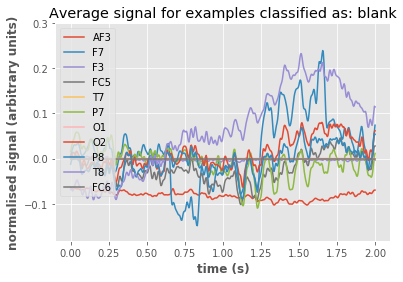

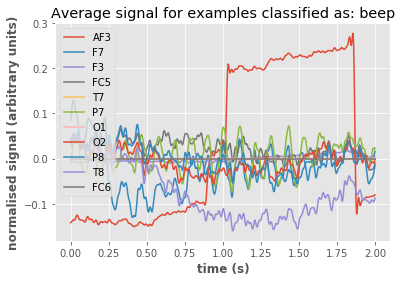

Done making training/test-sets, shapes:  (360, 128, 11) (360, 2) (40, 128, 11) (40, 2)


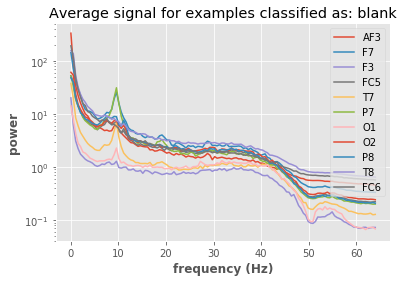

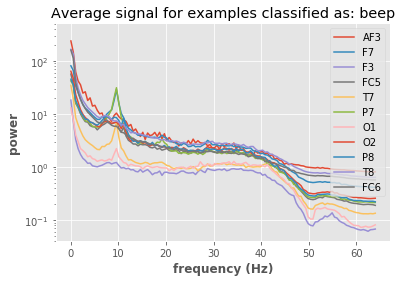

done


In [38]:
experiments = ['beeps']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = False, comment = 'CQ-Norm',
         preprocessing = True, ICA = False, noiseValue = 1e8, onlyOneFold = False, skip = False, patience = 15)
print('done')

last event at time:  603631.0
Done making training/test-sets, shapes:  (2070, 257, 14) (2070, 2) (230, 257, 14) (230, 2)


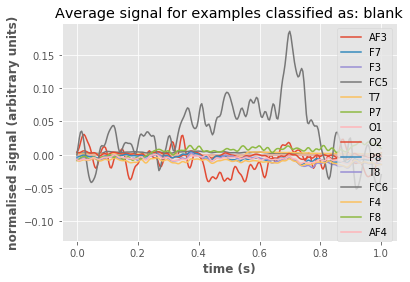

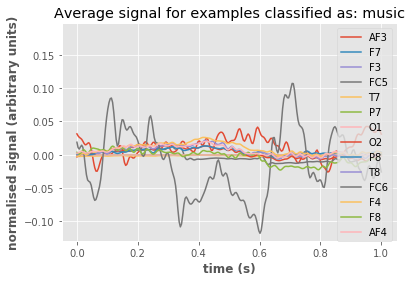

Done making training/test-sets, shapes:  (2300, 257, 14) (2300, 2) (0, 257, 14) (0, 2)
denoising autoencoder
Done making training/test-sets, shapes:  (4493, 257, 14) (4493, 1) (500, 257, 14) (500, 1)
4493 train samples
500 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 257, 14, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 257, 14, 32)       4128      
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 14, 16)        4112      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 14, 16)       0         
______________________________________

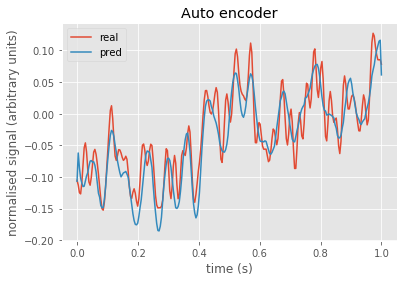

done


In [89]:
experiments = ['music']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = True, comment = 'CQ-Norm',
         preprocessing = True, ICA = False, noiseValue = 1e8, onlyOneFold = False, skip = False, patience = 15)
print('done')

last event at time:  265475.0
Done making training/test-sets, shapes:  (882, 257, 14) (882, 2) (98, 257, 14) (98, 2)


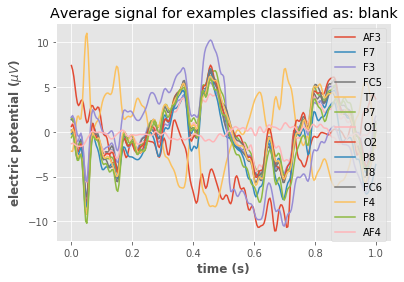

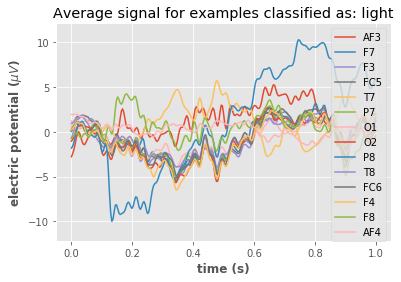

Done making training/test-sets, shapes:  (882, 64, 14) (882, 2) (98, 64, 14) (98, 2)


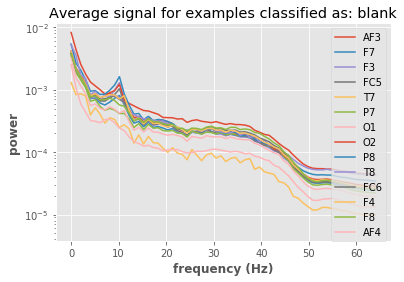

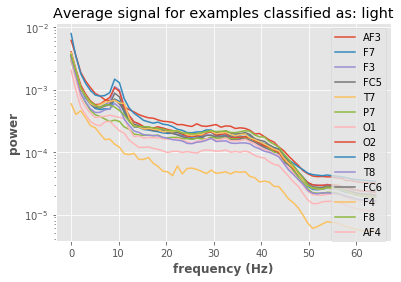

last event at time:  265475.0
Done making training/test-sets, shapes:  (441, 513, 14) (441, 2) (49, 513, 14) (49, 2)


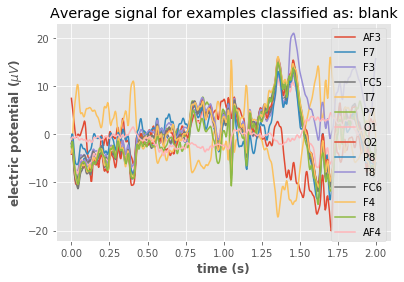

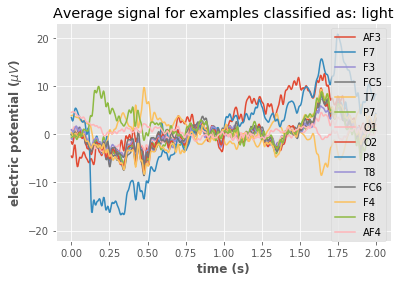

Done making training/test-sets, shapes:  (441, 128, 14) (441, 2) (49, 128, 14) (49, 2)


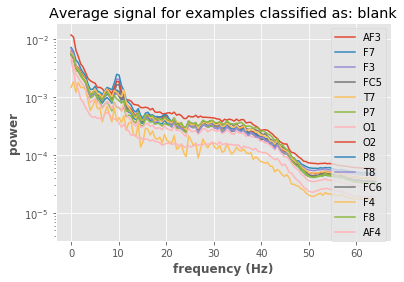

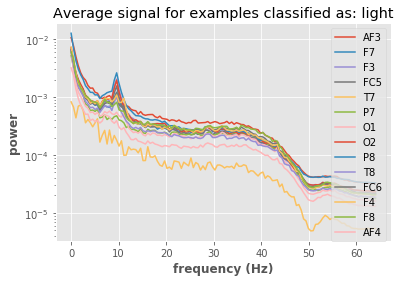

last event at time:  265475.0
Done making training/test-sets, shapes:  (88, 2561, 14) (88, 2) (10, 2561, 14) (10, 2)


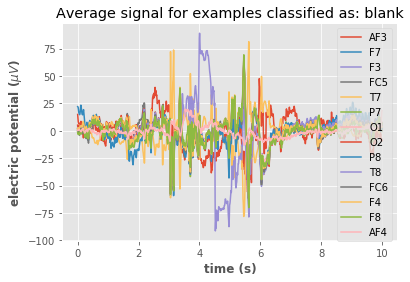

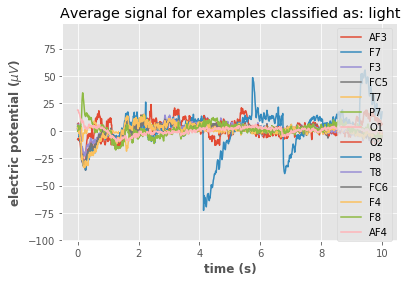

Done making training/test-sets, shapes:  (88, 640, 14) (88, 2) (10, 640, 14) (10, 2)


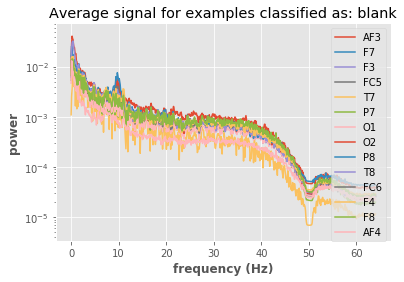

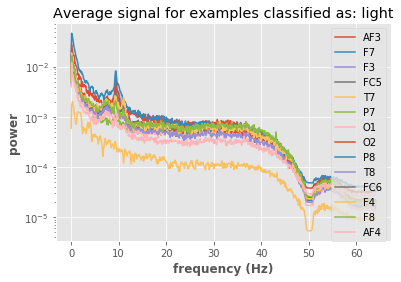

done


In [100]:
experiments = ['light']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = False, comment = 'CQ-Norm',
         preprocessing = False, ICA = False, noiseValue = 1e8, onlyOneFold = False, skip = False, patience = 15)
print('done')

last event at time:  265475.0
Done making training/test-sets, shapes:  (877, 257, 14) (877, 2) (98, 257, 14) (98, 2)


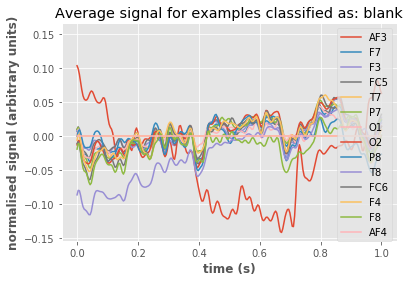

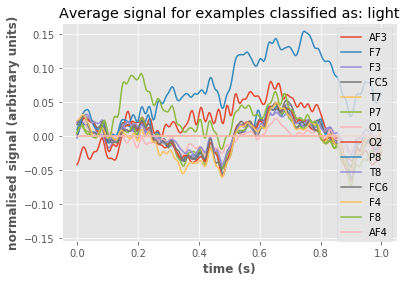

Done making training/test-sets, shapes:  (877, 64, 14) (877, 2) (98, 64, 14) (98, 2)


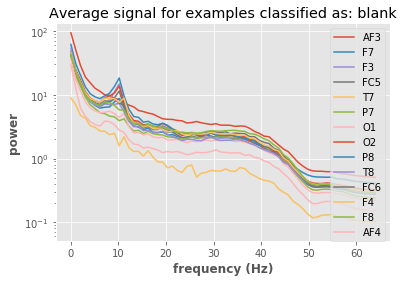

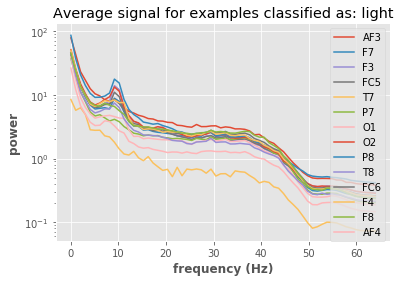

last event at time:  265475.0
Done making training/test-sets, shapes:  (436, 513, 14) (436, 2) (49, 513, 14) (49, 2)


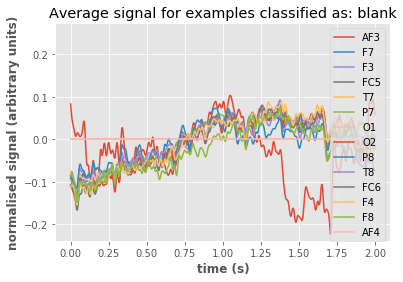

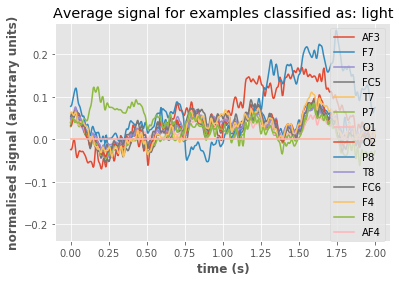

Done making training/test-sets, shapes:  (436, 128, 14) (436, 2) (49, 128, 14) (49, 2)


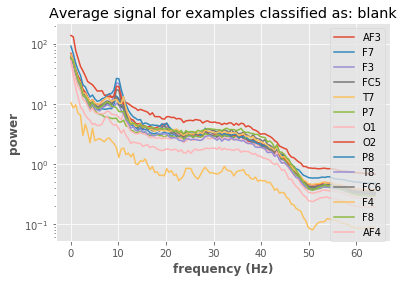

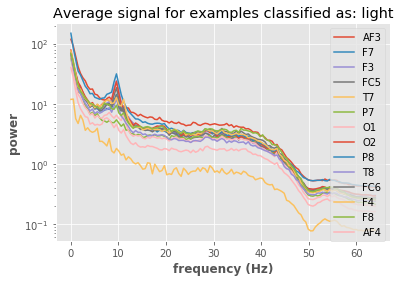

last event at time:  265475.0
Done making training/test-sets, shapes:  (85, 2561, 14) (85, 2) (10, 2561, 14) (10, 2)


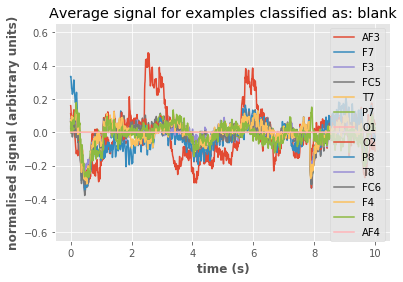

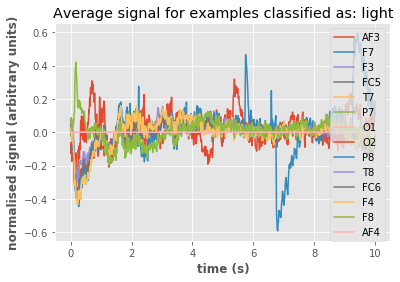

Done making training/test-sets, shapes:  (85, 640, 14) (85, 2) (10, 640, 14) (10, 2)


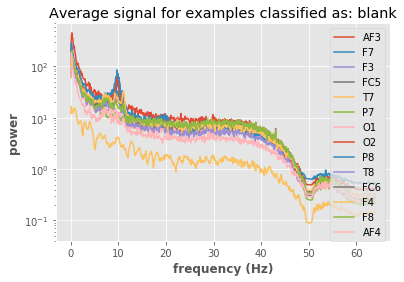

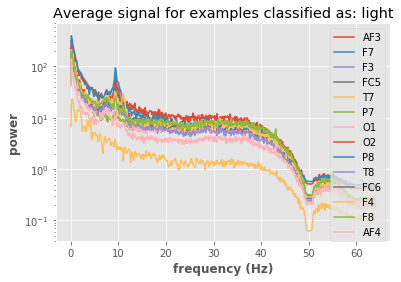

done


In [102]:
experiments = ['light']
for experiment in experiments:
    main(experiment, plot = True, trainClassifiers = False, comment = 'CQ-Norm-ICA',
         preprocessing = True, ICA = True, noiseValue = 3e-3, onlyOneFold = False, skip = False, patience = 15)
print('done')